# Metody uczenia maszynowego 2017 - Regresja

<h3 id=tocheading>Spis treści</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

In [38]:
from __future__ import print_function, unicode_literals

import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

from sklearn.datasets import load_boston, load_diabetes, load_linnerud
from sklearn.datasets import make_regression
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
from sklearn.datasets import make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, mean_squared_error

In [39]:
from astroML.datasets import fetch_imaging_sample
from sklearn.preprocessing import PolynomialFeatures
from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

# Regresja liniowa

## Zadanie regresji liniowej
* __Regresja__: modelowanie związku między zmienną _zależną_ $y$ generowaną przez __system__ a zmiennymi _niezależnymi_ ($x_1, x_2, \dots$), które aktywują ten system. Związek jest zadany przez dodanie niezależnego czynnika _szumu_ $\eta$, który jest zmienną _ukrytą_
$$y=f(x)+\eta\hspace{5ex}\eta\sim\mathcal{N}(0,\sigma)$$
  * modelowana zmienna zależna jest zwykle __ciągła__  
* Celem regresji (liniowej) jest estymacja wektora parametrów $\theta$ dla zbioru danych $\{(x_i, y_i)\}_{i=1}^{N}$ jako relacji 
$$y=\theta_0+\theta_1x_1+\dots+\theta_px_p=\theta_0+\theta^T{}x+\eta=[\theta_0,\theta]^T[1,x]+\eta=\theta^Tx+\eta,$$ 
gdzie $\theta_0$ to _bias_.
* regresja jest zadaniem uczenia __nadzorowanego__
  
* W modelu __regresji liniowej__ mamy model $\hat{y}=\hat{\theta}^Tx$
  * ten model jest modelem liniowym zmiennych wejściowych
  * będziemy także budować modele liniowe __parametrów__, ale złożonych funcji wejść
  
* W metodzie __minimalnych kwadratów least squares__ __LS__ funkcja kosztu
$$L(\theta)=\sum_{i=1}^{N}(y_i-\theta^Tx_i)^2$$ 

Biorąc gradient ze względu na $\theta$
$$\nabla{}L(\theta)=\nabla\sum_{i=1}^{N}(y_i-\theta^Tx_i)^2=2\sum_{i=1}^{N}(y_i-\theta^Tx_i)x_i^T$$
i przyrównując do zera otrzymujemy
$$\left(\sum_ix_ix^T_i\right)\hat{\theta}=\sum_ix_iy_i$$ 
co można zapisać jako 
$$X^TX\hat{\theta}=X^Ty,$$ 
gdzie $y=[y_1,y_2,\dots,y_N]^T$ co daje rozwiązanie __LS__ jako 
$$\boxed{
\hat{\theta}=(X^TX)^{-1}X^Ty\;}$$ 
pod warunkiem istnienia $(X^TX)^{-1}$.
  
* Jeśli $(p+1)\times(p+1)$ wymiarowa macierz $X^TX$ jest odwracalna, to rozwiązanie jest __unikalne__ ze względu na _wypukłość_ i paraboliczny kształt funkcji kosztu LS.

## Prosty przykład

In [5]:
sns.set(font_scale=1.5)

In [6]:
def simple_linear_regression():
    fig, ax = plt.subplots(1, 3, figsize=(19, 6))
    n_samples = 500
    bias = 10.0
    X, y, true_coef = make_regression(n_samples=n_samples, n_features=1, 
                                      n_targets=1, bias=bias, noise=10.0, 
                                      coef=True)
    ax[0].set_xlim((np.min(X), np.max(X)))
    ax[0].set_ylim((np.min(y), np.max(y)))
    ax[1].set_xlim((np.min(X), np.max(X)))
    ax[1].set_ylim([np.min(y), np.max(y)])
    regr = LinearRegression()
    regr.fit(X, y)
    print("Cały zbiór uczący")
    print("\ttrue/computed coefficients: {:.3f}/{:.3f}, bias = {:.3f}".format(float(true_coef), 
                                                                  float(regr.coef_), 
                                                                  bias))
    print("\tresidual error = {:.3f}".format(np.mean((regr.predict(X) - y) ** 2)))
    print("\tscore = {:.3f}".format(regr.score(X, y)))
    ax[0].scatter(X, y, color='black', s=8)
    ax[0].plot(X, regr.predict(X), color='blue', linewidth=1)
    ax[0].set_title('Cały zbiór uczący')

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    regr.fit(X_train, y_train)
    print("train/test model")
    print("\ttrue/computed coefficients: {:.3f}/{:.3f}, bias = {:.3f}".format(float(true_coef), 
                                                                  float(regr.coef_), 
                                                                  bias))

    print("\tresidual error = {:.3f}".format(np.mean((regr.predict(X_test) - y_test) ** 2)))
    print("\tscore = {:.3f}".format(regr.score(X, y)))
    ax[1].scatter(X_train, y_train, color='black', s=8)
    ax[1].scatter(X_test, y_test, color='red', s=8)
    ax[1].plot(X, regr.predict(X), color='blue', linewidth=1)
    ax[1].set_title('Zbiór uczący/testujący')

    # ewaluacja wyników przez walidację krzyżową
    pred = cross_val_predict(regr, X, y, cv=10)
    ax[2].set_xlim([np.min(y), np.max(y)])
    ax[2].set_ylim([np.min(y), np.max(y)])
    ax[2].plot([y.min(), y.max()], [y.min(), y.max()], lw=1)
    ax[2].scatter(y, pred, s=8)
    ax[2].set_title('Walidacja krzyżowa')

    for i in range(3):
        ax[i].set_xlabel("Prawdziwe wartości")
    ax[0].set_ylabel("Przewidziane")

    fig.tight_layout()

Cały zbiór uczący
	true/computed coefficients: 51.220/51.299, bias = 10.000
	residual error = 100.366
	score = 0.962
train/test model
	true/computed coefficients: 51.220/51.320, bias = 10.000
	residual error = 89.563
	score = 0.962


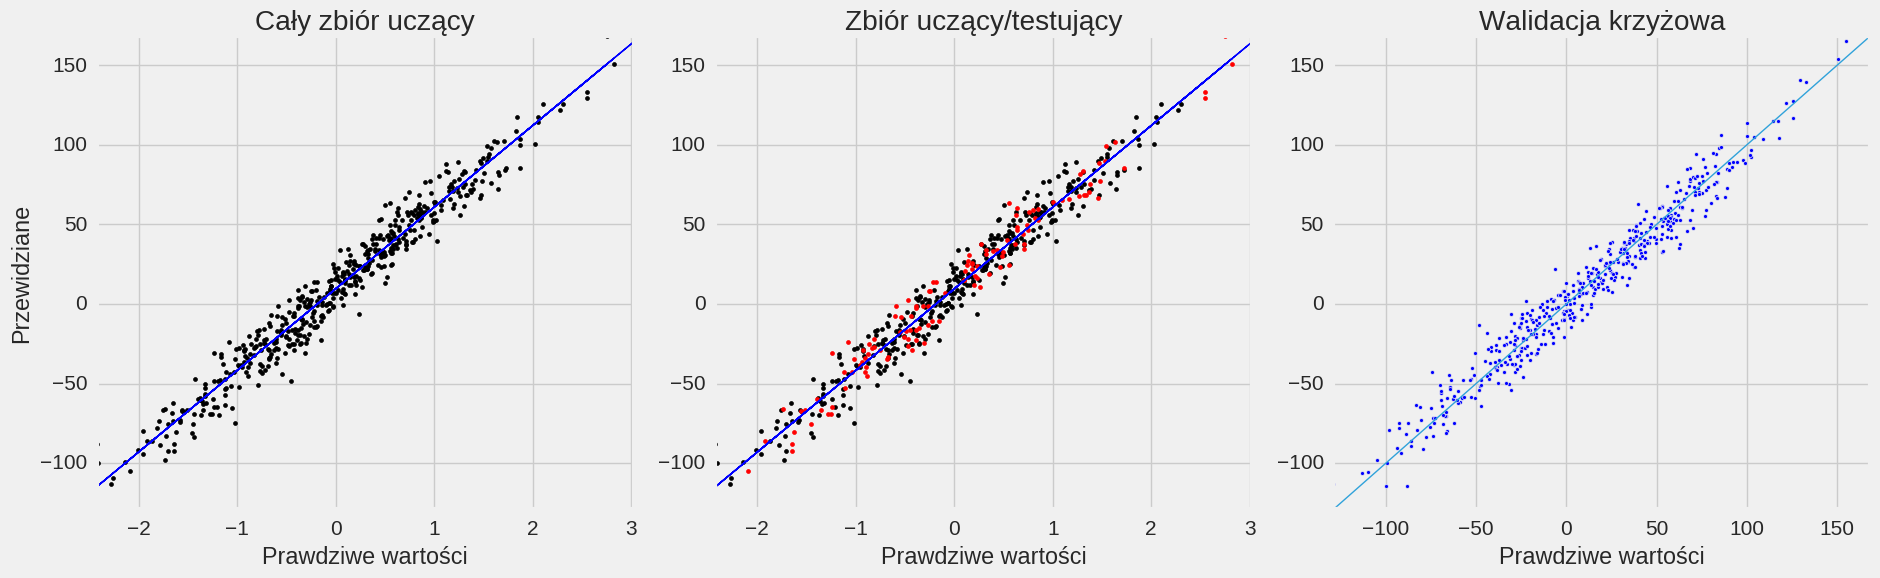

In [40]:
simple_linear_regression()

## Struktura geometryczna predykcji 

<img src="../mum_figures/regressionGeometricInterpretation.png" width="45%"/>
* punkty $(\hat{y}_k, x_{k1}, \dots, x_{kp})$ leżą na $p+1$ wymiarowej __hiperpłaszczyźnie__ 
* punkty leżą na $p+2$ wymiarowej hiperpłaszczyźnie jeśli dodatkowa wartość $1$ jest dodana do $x$
* liniowa regresja może być użyta nawet jeśli rzeczywista zależność danych generowanych przez system nie jest liniowa
* jakość predykcji zależy od szumu w systemie; inne rodzaje regresji mogą być skuteczniejsze gdy szum jest wysoki
  
  
* __warunek ortogonalności__ $$\mathbb{E}[x(y-\theta_\ast x)]=\mathbb{E}[xe_\ast]$$ mówi, że __błąd__ estymacji jest ortogonalny do przykładów

## Regresja liniowa wielowartościowa (multivariate)

* Regresję liniową można również wykorzystać do przypadków, gdy wartość celu (target) pojedynczego przykładu jest wektorem. 

In [41]:
def multivariate_linnerud_set():
    linn = load_linnerud()
    fig, ax = plt.subplots(3, 3, figsize=(18, 12))
    for i in range(3):
        ax[i, 0].set_ylabel(linn.target_names[i])
        ax[2, i].set_xlabel(linn.feature_names[i])
    for i in range(3):
        for j in range(3):
            ax[i, j].scatter(linn.data[:, i], linn.target[:, j])
    fig.tight_layout()
    lr = LinearRegression()
    lr.fit(linn.data, linn.target)
    print("Znalezione współczynniki estymacji:\n", lr.coef_)

Znalezione współczynniki estymacji:
 [[-0.475 -0.218  0.093]
 [-0.137 -0.04   0.028]
 [ 0.001  0.042 -0.029]]


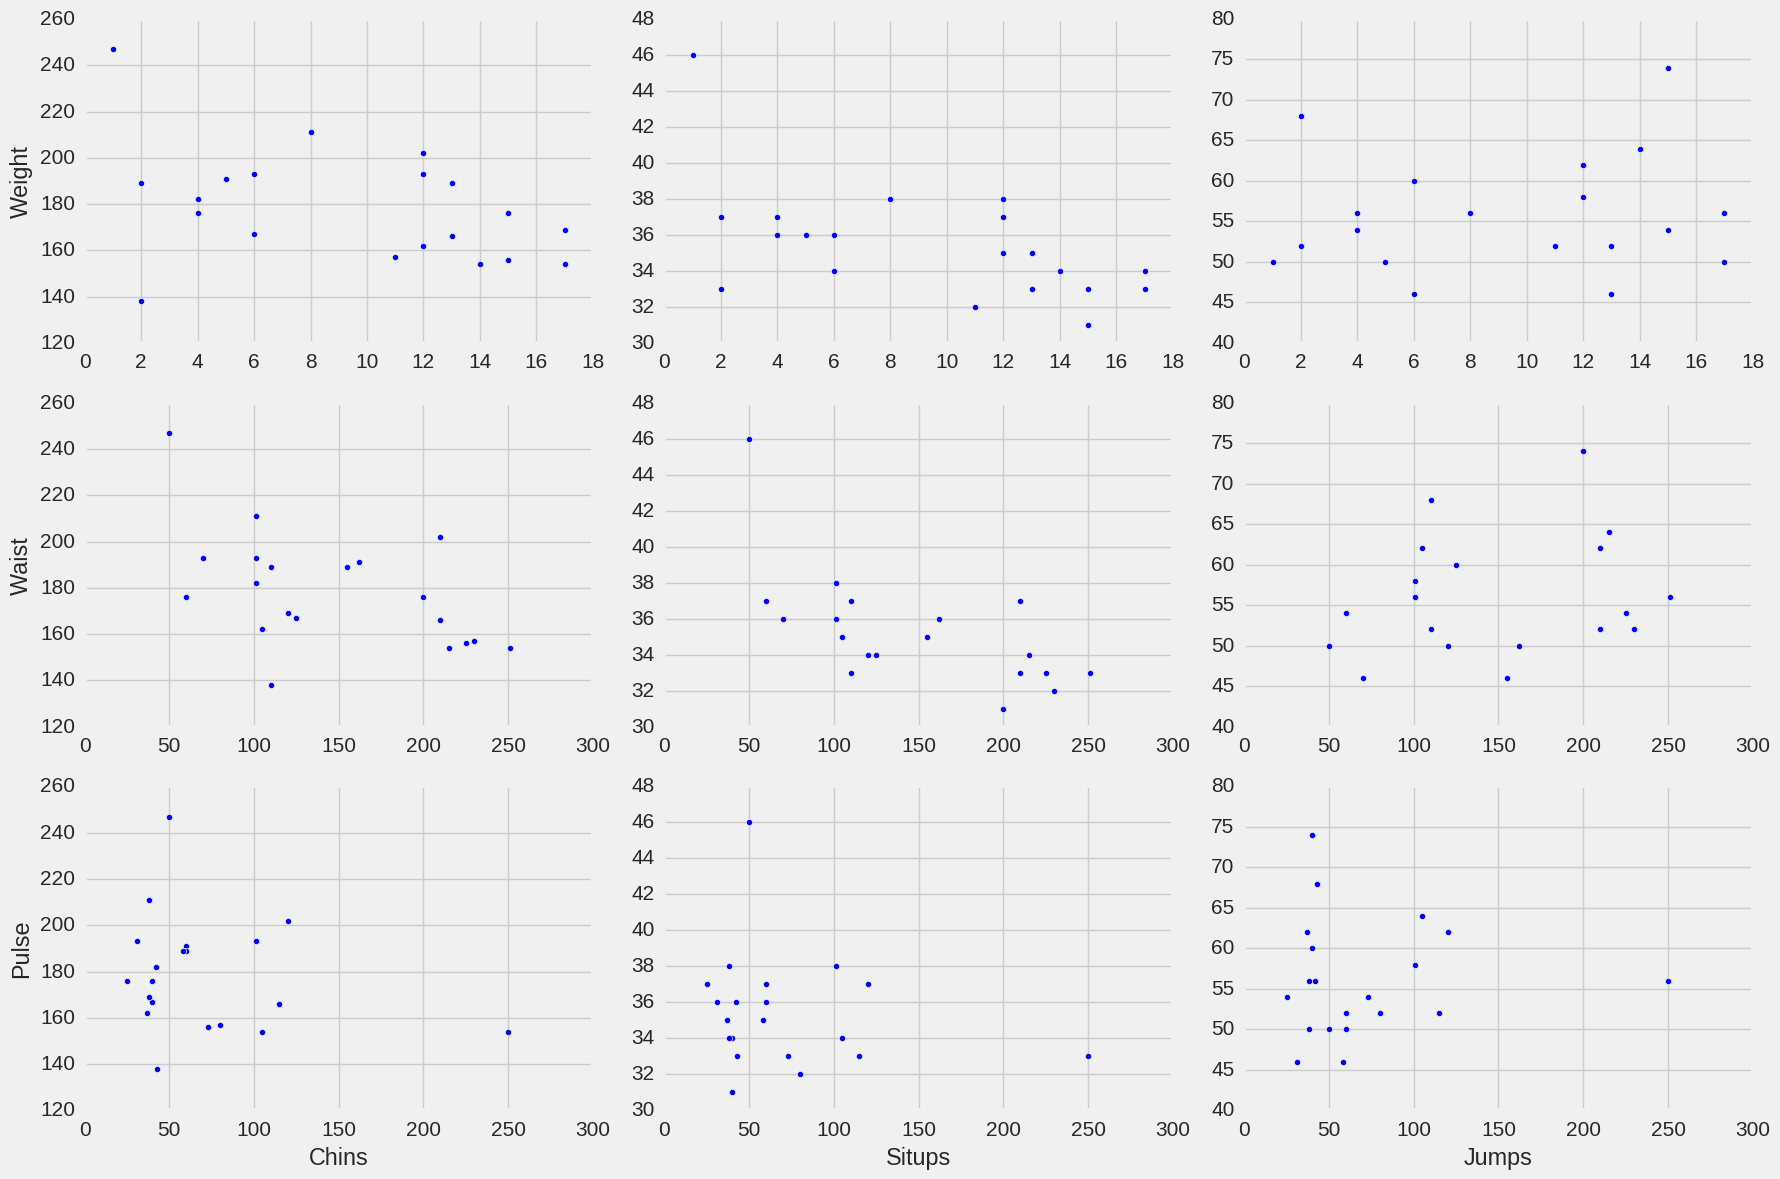

In [42]:
multivariate_linnerud_set()

In [15]:
def multivariate_regression():
    n_samples = 200 
    # data = make_friedman1(n_samples=n_samples)              ## koduje targety z wykorzystaniem wielomianów i sinusa (10 --> 1)
    # X, y = make_friedman2(n_samples=n_samples)              ## używa mnożenia i dzielenia cech wejsciowych (4 --> 1)
    # X, y = make_friedman3(n_samples=n_samples)              ## arctan na targecie (4 --> 1)
    X, y = make_sparse_uncorrelated(n_samples=n_samples)    ## liniowa kombinacja czterech wejść (4 --> 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    fig, ax = plt.subplots(2, 2, figsize=(22, 20))
    for i in range(2):
        for j in range(2):
            ax[i, j].scatter(X_train[:, 2 * i + j], y_train, c='blue')
            ax[i, j].scatter(X_test[:, 2 * i + j], y_test, c='red')
    fig.tight_layout()
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print("Linear regression score: {}".format(lr.score(X_test, y_test)))
    sgd = SGDRegressor(loss='squared_loss', penalty='none', n_iter=5000, verbose=0)
    sgd.fit(X_train, y_train)
    print("Stochastic gradient descent score: {}".format(sgd.score(X_test, y_test)))

Linear regression score: 0.908232053924
Stochastic gradient descent score: 0.90820531794


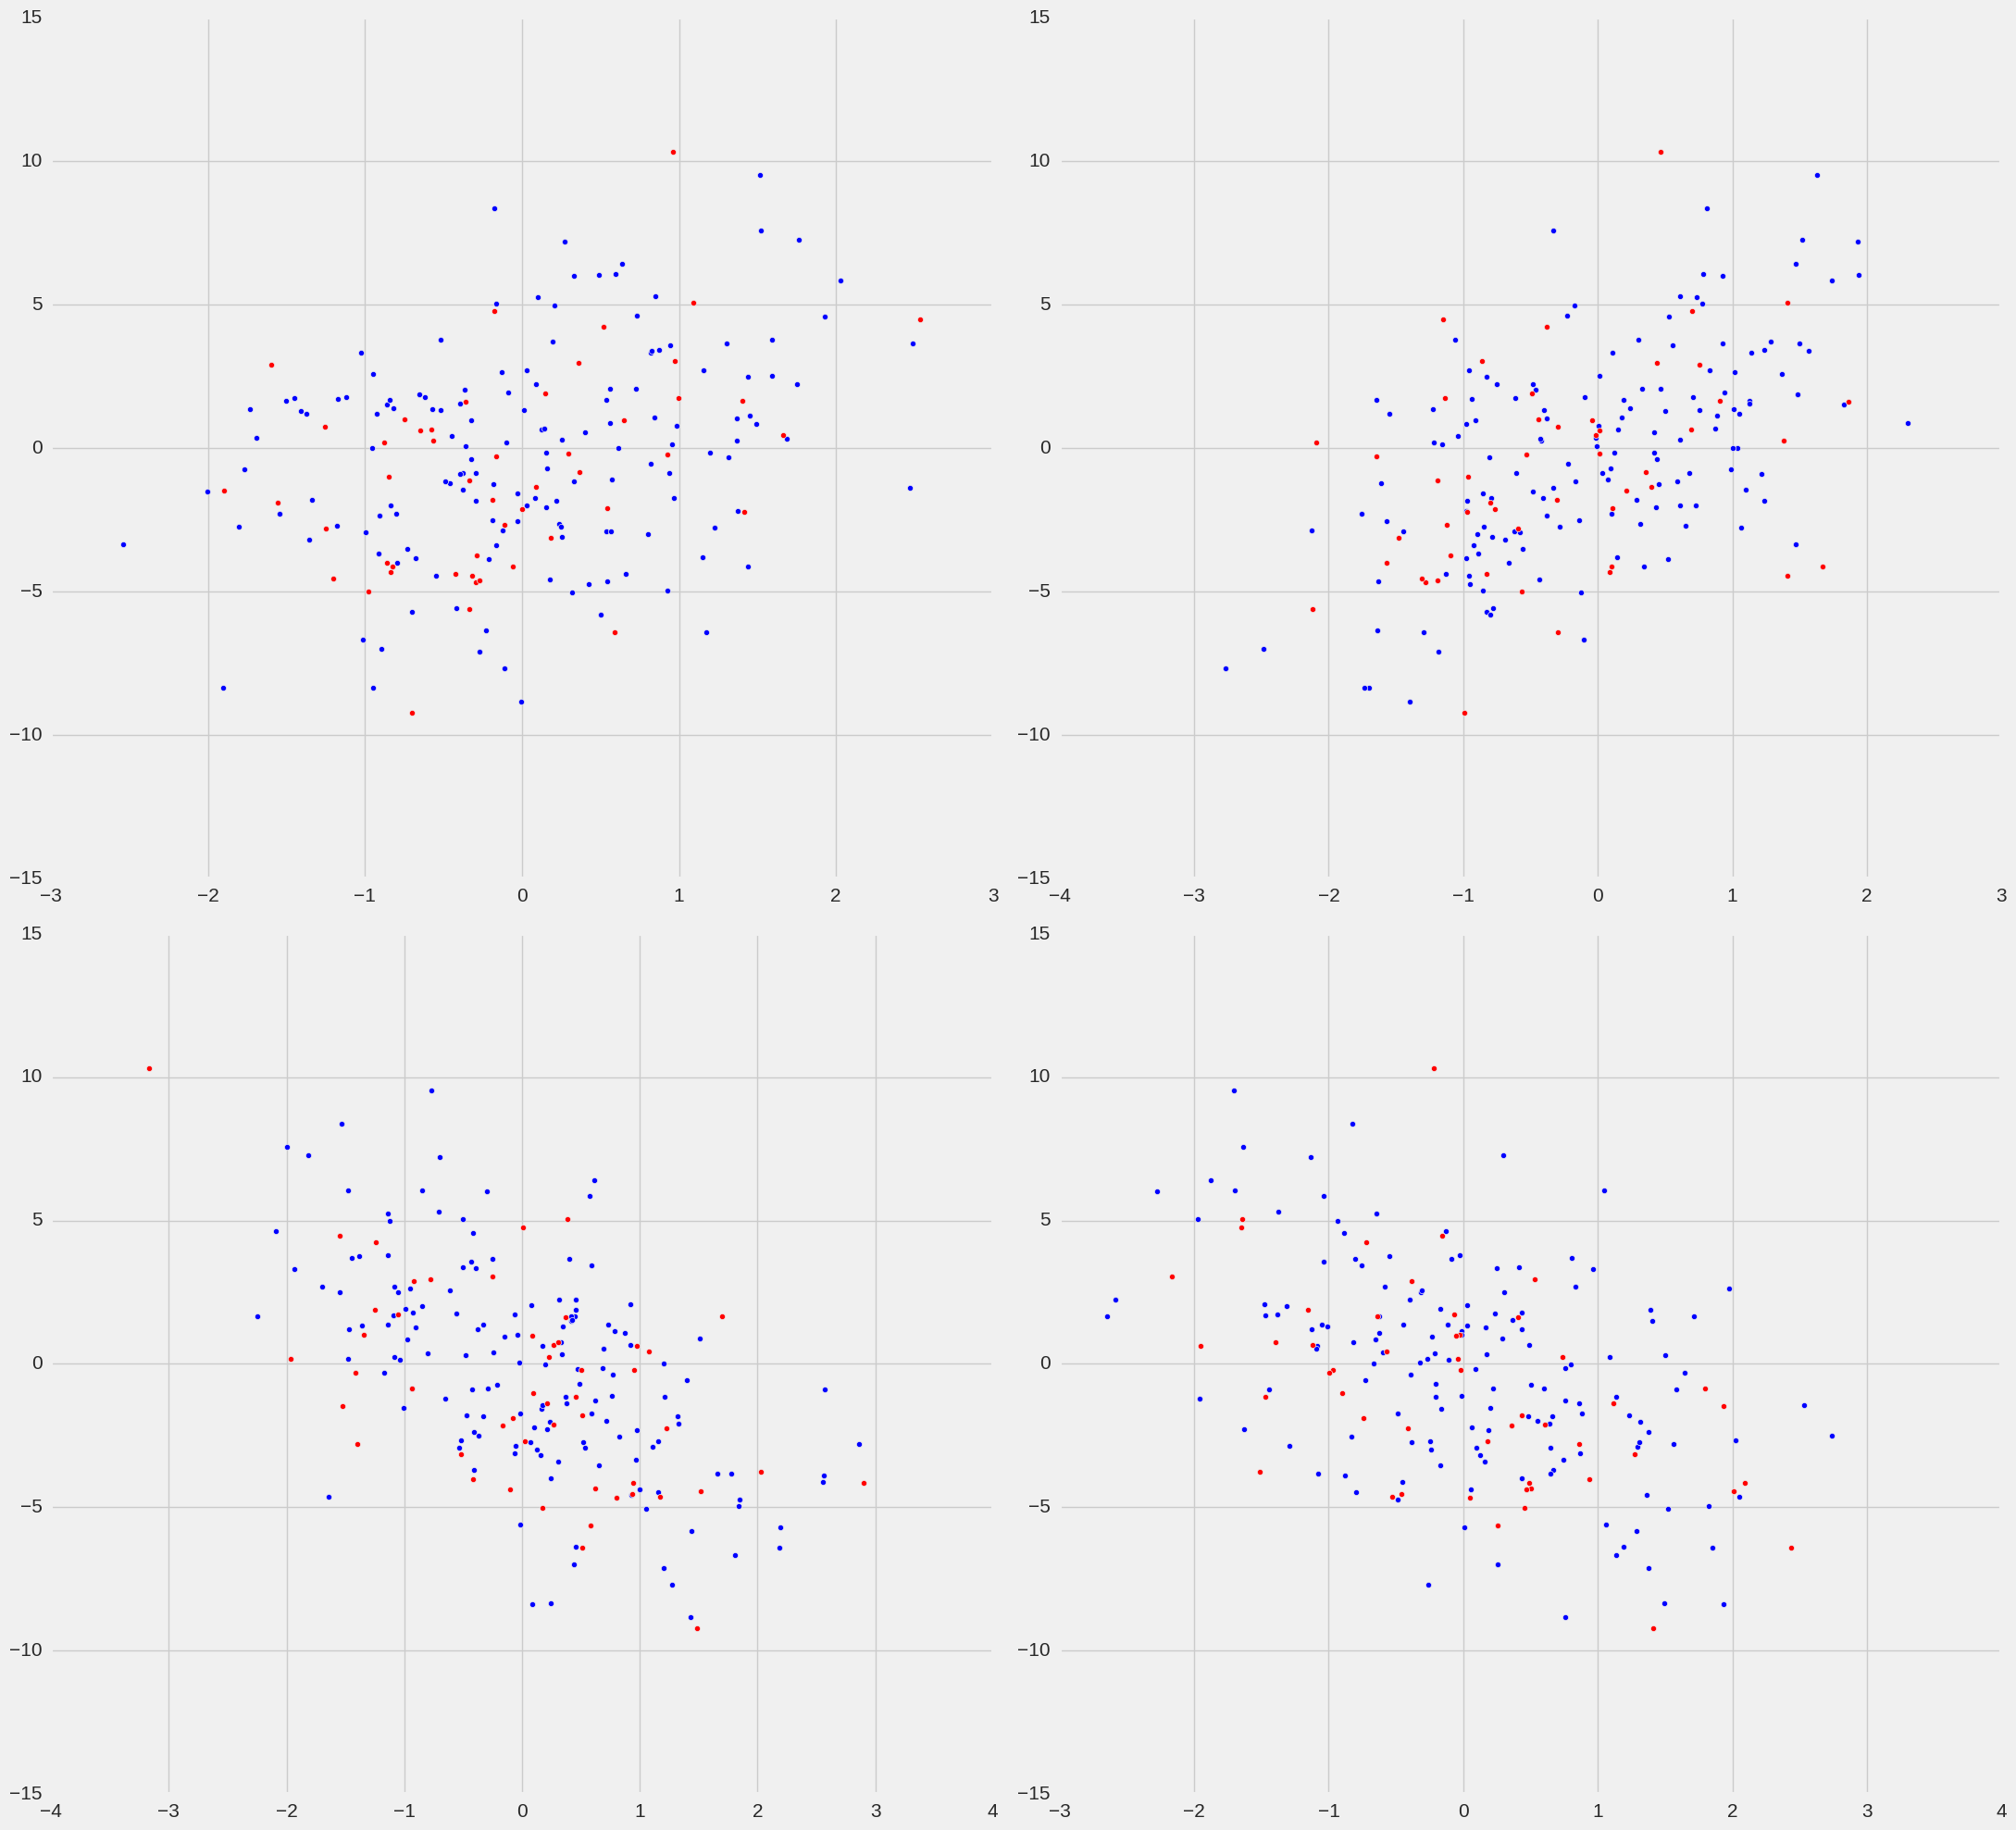

In [43]:
multivariate_regression()

## Mean Square Error

* Niech $\hat\theta$ będzie zmienną losową opisującą estymator, którego prawdziwą wartością jest $\theta_{opt}$ 
* Jeśli używamy kwadratowej funkcji kosztu, to _rozsądną_ miarą skuteczności estymatora będzie _mean-square error_ __MSE__ $$MSE=\mathbb{E}[(\hat\theta-\theta_{opt})^2]$$
gdzie średnia $\mathbb{E}$ jest brana po _wszystkich_ możliwych zbiorach danych o rozmiarze $N$
* Mała wartość $MSE$ powinna dawać skuteczny estymator

### Rozwiązanie dla problemu MSE

* Optymalne przybliżenie $y$ dla danego $x$ jest $\hat{y}=\mathbb{E}[y|x]$. Niech model $g(x)$ bedzie funkcją liniową

* Szukamy takiego $\theta$ dla $\hat{y}=\theta^Tx$, że $L(\theta)=\mathbb{E}[(y-\hat{y})^2]$ będzie __minimalne__, a więc
$$\boxed{\theta_\ast=\underset{\theta}{\arg\min}\;L(\theta)\;}$$
  * niech $(x, y)$ mają zerowe wartości oczekiwane
    * jeśli tak nie jest, to wartości średnie mogą być odjęte
    
    
* Celem estymatora jest minimalizacja zmiennej losowej błędu $$e=y-\hat{y}$$ 

* Minimalizacja funkcji kosztu odpowiada przyrównaniu jej gradientu do zera 

$$\begin{align}
\nabla{}L(\theta)&=\nabla\mathbb{E}[(y-\theta^Tx)(y-\theta^Tx)]\\
&=\nabla\left[\mathbb{E}[y^2]-2\theta^T\mathbb{E}[xy]+\theta^T\mathbb{E}[x x^T]\theta\right]\\
&=-2p+2\mathbb{E}[xx^T]\theta=0
\end{align},$$

gdzie 
$$p=\left[\mathbb{E}[x_1y],\mathbb{E}[x_2y],\dots,\mathbb{E}[x_py]\right]=\mathbb{E}[xy]$$
jest __macierzą kowariancji__ oraz układ równań 
$$\boxed{\mathbb{E}[x x^T]\theta_{\ast}=p\;}$$
  

* parametry optymalnego rozwiązania mogą być znalezione przez rozwiązanie układu równań,
* rozwiązanie istnieje jeśli macierz kowariancji jest _dodatnio określona_ i może być odwrócona,
* w takiej sytuacji rozwiązanie jest _unikalne_,
* w przeciwnej sytuacji istnieje nieskończenie wiele rozwiązań.

#### Interpretacja geometryczna

* dwie _nieskorelowane_ zmienne $$\mathbb{E}[xt]=0$$ będziemy nazywać __ortogonalnymi__ względem siebie
* rozwiązanie _liniowego_ estymatora można zapisać jako $$y=\theta^Tx=\theta_1x_1+\dots+\theta_l x_l$$
  * zadanie jest w $N$ wymiarowej przestrzeni rozpinanej przez punkty $t_n$
  * wartość estymacji $y$ będzie leżeć __na powierzchni__ rozpinanej przez punkty danych $x_i$
  <img src="../mum_figures/regressionGeometricInterpretation.png" width="60%"/>[rysunek z Bishopa]
    * albo przez wartości $\varphi_i(x)$
    * jeśli liczba funkcji bazowych $M$ jest mniejsza od liczby danych $N$, to wektory $\phi(x_n)$ (wiersze macierzy $\Phi$) będą rozpinały podprzestrzeń
  * prawdziwa wartość $t$ z reguły __nie będzie__ leżeć na tej powierzchni
    * błąd to odległość euklidesowa między $y$ a $t$
  * celem jest znalezienie dobrej estymacji, a więc zminimalizowanie normy __błędu__ $e=t-y$, gdzie $$\|x\|=\sqrt{\mathbb{E}[x^2]}$$
  * to odpowiada żądaniu __ortogonalności błędu względem podprzestrzeni rozpinanej przez punkty__ $$\mathbb{E}[ex_k]=0\;\text{dla}\;k=1,\dots,l\tag{*}$$
    * (prawie)-kolinearność wektorów bazowych $\phi_j$ będzie prowadzić do problemów numerycznych
    * potrzebne dodatkowe techniki
  
  * rozpisując (*)
  $$\begin{align}
  \mathbb{E}\left[\left(t-\sum_{i=1}^l\theta_ix_i\right)x_k\right]=\mathbb{E}\left[x_kt-\sum_i\theta_ix_ix_k\right]=0
  \end{align}$$
  czyli $$\sum_{i=1}^l\mathbb{E}[x_ix_k]\theta_i=\mathbb{E}[x_kt]$$
  * ten zbiór liniowych równań jest nazywany _równaniami Wienera-Hopfa_
  

---

>Norbert Wiener był matematykiem i filozofem. Otrzymał doktorat z logiki matematycznej na Harwardzie w wieku 17 lat. W czasie II wojny światowej dał, niezależnie od Kołogorowa, podwaliny pod teorię estmacji liniowej. Pracował później przy automatyce i cybernetyce, sztucznej inteligencji, kognitywistyce. Ponieważ był pacyfistą, przez całe lata Zimnej Wojny był traktowany podejrzliwie 

<img src="../mum_figures/wiener.png" width="55%"/>

## Funkcje bazowe
* zamiast prostego modelu regresji liniowej, możemy wybrać model __liniowy z funkcjami bazowymi__
$$y(x)=\theta_0+\sum_j\theta_j\phi_j(x)=\theta^T\Phi(x)$$
gdzie $\phi_j()$ są funkcjami bazowymi
  * funkcje bazowe mogą wynikać z jakiegoś wstępnego przetwarzania danych
    * to doda jakąś wiedzę aprioryczną
  * jeśli $\phi()$ będą nieliniowe, to cały model też będzie nieliniowy względem $x$
    * w dalszym ciągu będziemy mówić o nim jako modelu liniowym względem parametrów
  * częstym wyborem są funkcje wielomianowe $\phi_j(x)=x^j$
    * wielomiany są funkcjami globalnymi
    * zmiany w jednym obszarze wpływają na wszystkie inne
    * rozwiązaniem są funkcje __spline__: podział na podobszary i różne wielomiany w nich
  * także częste są funkcje __lokalne__
    * gausowskie 
    $$\phi_j(x)=\exp\left(-\frac{(x-\mu_j)^2}{2\sigma^2}\right)$$
    * sigmoidalne $$\phi_j(x)=\sigma\left(\frac{x-\mu_j}{a}\right)$$
  * także Fourierowskie i wavelets

In [44]:
def draw_basis_functions(n = 10):
    fig, ax = plt.subplots(1, 3, figsize=(26,8))
    x = np.linspace(-1, +1, 100)
    for k in range(1, n):
        ax[0].plot(x, x ** k)
        ax[0].set_title('wielomianowe')
        ax[1].plot(x, np.exp(-((x - (2 * float(k) / float(n) - 1.)) ** 2) / 0.05))
        ax[1].set_title('gausowskie')
        ax[2].plot(x, 1. / (1. + np.exp(-(x - (2 * float(k) / float(n) - 1.)) / 0.05)))
        ax[2].set_title('sigmoidalne')

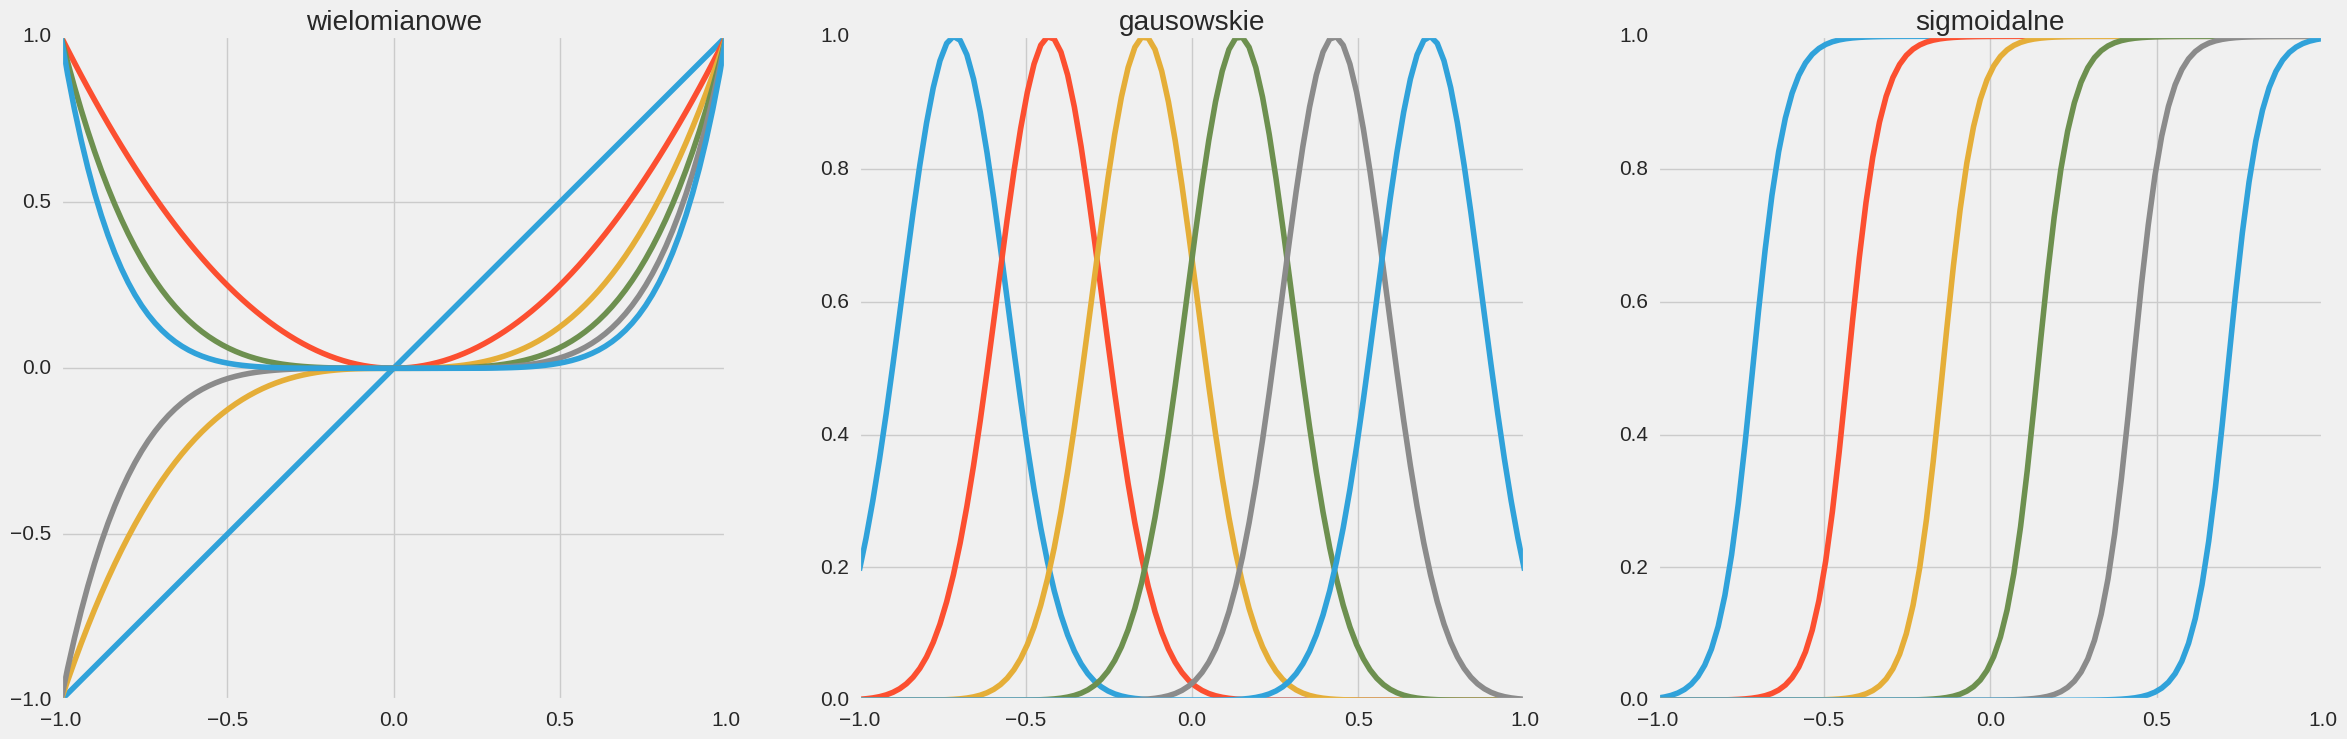

In [45]:
draw_basis_functions(n=7)

## Maximum likelihood
* niech wartość docelowa $t$ będzie dana jako funkcja z gaussowskim szumem
$$t=y(x;\theta)+\epsilon$$
  * zakładamy unimodalny szum
* prawdopodobieństwo danych
$$p(t|x,\theta,\sigma)=\mathcal{N}(t|y(x,\theta),\sigma)$$
* niech dany będzie zbiór przykładów $X=\{x_1,\dots,x_N\}$ z wartościami $t=(t_1,\dots,t_N)$
* stąd mamy postać funkcji likelihood dla danych
$$p(t|X,\theta,\sigma)=\prod_{n=1}^N\mathcal{N}(t_n|\theta^T\phi(x_n),\sigma)$$
oraz funkcję log-likelihood
$$\begin{align}
\ln p(t|\theta,\sigma)&=\sum_{n=1}^N\ln\mathcal{N}(t_n|\theta^T\phi(x_n),\sigma)\\
&=-\frac{N}{2}\sigma-\frac{N}{2}\ln(2\pi)-\sigma\frac{1}{2}\sum_{n=1}^N\left[t_n-\theta^T\phi(x_n)\right]^2
\end{align}$$
  * maksymalizacja likelihood będzie równoważna minimalizacji log-likelihood
  $$\begin{align}
 \nabla\ln{}p(t|\theta,\sigma)&=\sum_{n=1}^N\left[t_n-\theta^T\phi(x_n)\right]\phi(x_n)^T\\
 0&=\sum_{n=1}^Nt_n\phi(x_n)^T-\theta^T\left(\sum_{n=1}^N\phi(x_n)\phi(x_n)^T\right)
  \end{align}$$
  * rozwiązując ze względu na $\theta$ otrzymujemy
  $$\theta=(\Phi^T\Phi)^{-1}\Phi^Tt$$
    * macierz $\phi$ ma elementy $\Phi_{nj}=\phi_j(x_n)$ o wymiarach $N\times{}M$
    * macierz $$\Phi^\dagger=(\Phi^T\Phi)^{-1}\Phi^T$$ jest nazywana macierzą pseudo-odwrotną Moora-Penrose-a
    
    
* datąd było założenie, że $\phi_0(x)=1$
$$Err(\theta)=\frac{1}{2}\sum_{n=1}^N\left[t_n-\theta_0-\sum_{j=1}^{M-1}\theta^T\phi_j(x_n)\right]^2$$
  * minimalizując ze względu na $\theta_0$ dostajemy
  $$\theta_0=\bar{t}-\sum_{j=1}^{M-1}\theta_j\bar{\phi_j}$$
  gdzie $\bar{t}$ i $\bar{\phi_j}$ to średnie wartości
  * wartość $\theta_0$ umożliwia pracę dla zróżnicoanych wartości celu i wejść
  * stąd nazwa __bias__

### Przykład dla danych astronomicznych
* model ewolucji wszechświata
* relatywistyczny efekt Dopplera powoduje, że barwa obiektów (gwiazd) oddalających się od obserwatora ma przesunięcie ku czerwieni
* odległość jasnościowa opisuje relację między prawdziwą a obserwowalną jasnością obiektów gwiezdnych
* obie są pewną parametryzacją obrazującą rozszerzanie się wszechświata
* na rysunku użyte są dane wygenerowane z pewnego modelu kosmologicznego opisujące supernowe
* jest także pewien ogólny model teoretyczny
  
  
* zastosowanie w modelu astronomicznym pokazuje wiele problemów
  * rzeczywiste dane nie mogą być przedstawione w postaci zamkniętej ponieważ zawierają wariancję różną dla różnych obszarów (zwiększa się dla większych wartości przesunięcia ku czerwieni)
  * nie znamy rzeczywistej złożonosci modelu
  
* zastrzeżenie: model dofitowania poniżej nie bierze pod uwagę zmieniającej się niepewności danych, ich. _heteroskedastyczności_
  * wymaga zmiany modelu przez wprowadzenie macierzy wartości własnych macierzy kowriancji $X^TX$

In [46]:
def cosmo_poly(n_examples=100, classifier = 'linear', loss='squared_loss', 
               penalty='l1', degree_list=[3], scalecenter=True):
    if classifier != 'linear' and classifier != 'sgd':
        print('classifier incorrectly set to {}'.format(classifier))
        return

    fig, ax = plt.subplots(figsize=(22, 20))
    np.set_printoptions(precision=3)
    
    z_sample, mu_sample, dmu = generate_mu_z(n_examples, random_state=0)
    cosmo = Cosmology()
    z = np.linspace(0.01, 2, 1000)
    mu_true = np.asarray(map(cosmo.mu, z))
    # znalezc prawdziwe wartosci mu_true dla wartosci z z_sample
    # potrzebne dla obliczenia generalizacji
#    mu_sample_true = get_nearest_true_values(x=z_sample, z=z, mu_true=mu_true)

    basis_mu = np.linspace(0, 2, 15)[:, None]
    basis_sigma = 3 * (basis_mu[1] - basis_mu[0])
    
    # TODO jak zamienic int na liste?
    # obliczenie dofitowań
#    degree_list = list(degree)
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink']
    len_colors = len(colors)

    for k, dgr in enumerate(degree_list):
        # ekspansja wielomianow
        poly = PolynomialFeatures(degree=dgr)
        # TODO dac opcje wyboru klasyfikatora takze na SGDRegression i mozliwosc regularyzacji
        if classifier == 'linear':
            clf = LinearRegression(normalize=True)
            classifier_name = 'LinearRegression()'
        elif classifier == 'sgd':
            clf = SGDRegressor(loss=loss, penalty=penalty, n_iter=500)
            classifier_name = "SGDRegression()"

        # obliczenie funkcji bazowych dla wszystkich przykladow
        X_sample = poly.fit_transform(z_sample[:, None])
        if scalecenter:
            # skalowanie i centrowanie
            scaler = preprocessing.RobustScaler().fit(X_sample)
            X_sample = scaler.transform(X_sample)
        # fit expanded
        clf.fit(X_sample, mu_sample)

        # obliczenie dofitowania do danych
        mu_sample_fit = clf.predict(X_sample)
        # skalowanie dla calego z
        X_z = poly.fit_transform(z[:, None])
        if scalecenter:
            X_z = scaler.transform(X_z)
        mu_fit = clf.predict(X_z)
        
        # blad dopasowanie do przykladow uczacych
        chi2_dof = (np.sum(((mu_sample_fit - mu_sample) / dmu) ** 2) / (len(mu_sample - 1)))
        # miara generalizacji
        true_chi2_dof = (np.sum(((mu_fit - mu_true)) ** 2) / (len(mu_true - 1)))

        ax.plot(z, mu_fit, '-', c=colors[k % len_colors], label=r'degree = {}, chi^2 = {}, gen = {}'.format(dgr, 
                                                                                               np.round(chi2_dof, 3),
                                                                                               np.round(true_chi2_dof, 3)))
        ax.plot(z, mu_true, '--', c='gray')
        ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
        print("{:4d}: coef: {}".format(dgr, clf.coef_))

    ax.set_xlim(0.01, 1.8)
    ax.set_ylim(36.01, 48)
    ax.set_xlabel('przesunięcie ku czerwieni')
    ax.set_ylabel('odleglość jasnościowa')
    ax.set_title('Wielomianowa regresja jasności względem przesunięcia do podczerwieni gwiazd używajac {}'.format(classifier_name))
    ax.legend(loc='best')

   1: coef: [ 0.     1.754]
   2: coef: [ 0.     3.001 -0.894]
   3: coef: [ 0.     1.754  1.749 -1.043]
   4: coef: [ 0.     1.288  0.991  0.372 -0.403]
   5: coef: [      0.     -84436.1   -296764.571   14452.874  366242.6   -149659.905]
   6: coef: [  0.000e+00   4.602e+09   2.719e+09   6.845e+09   1.655e+10   2.203e+10
  -2.052e+10]
   7: coef: [  0.000e+00   1.108e+10   4.812e+09   4.048e+09   1.422e+10   4.123e+10
   7.880e+10   6.417e+10]


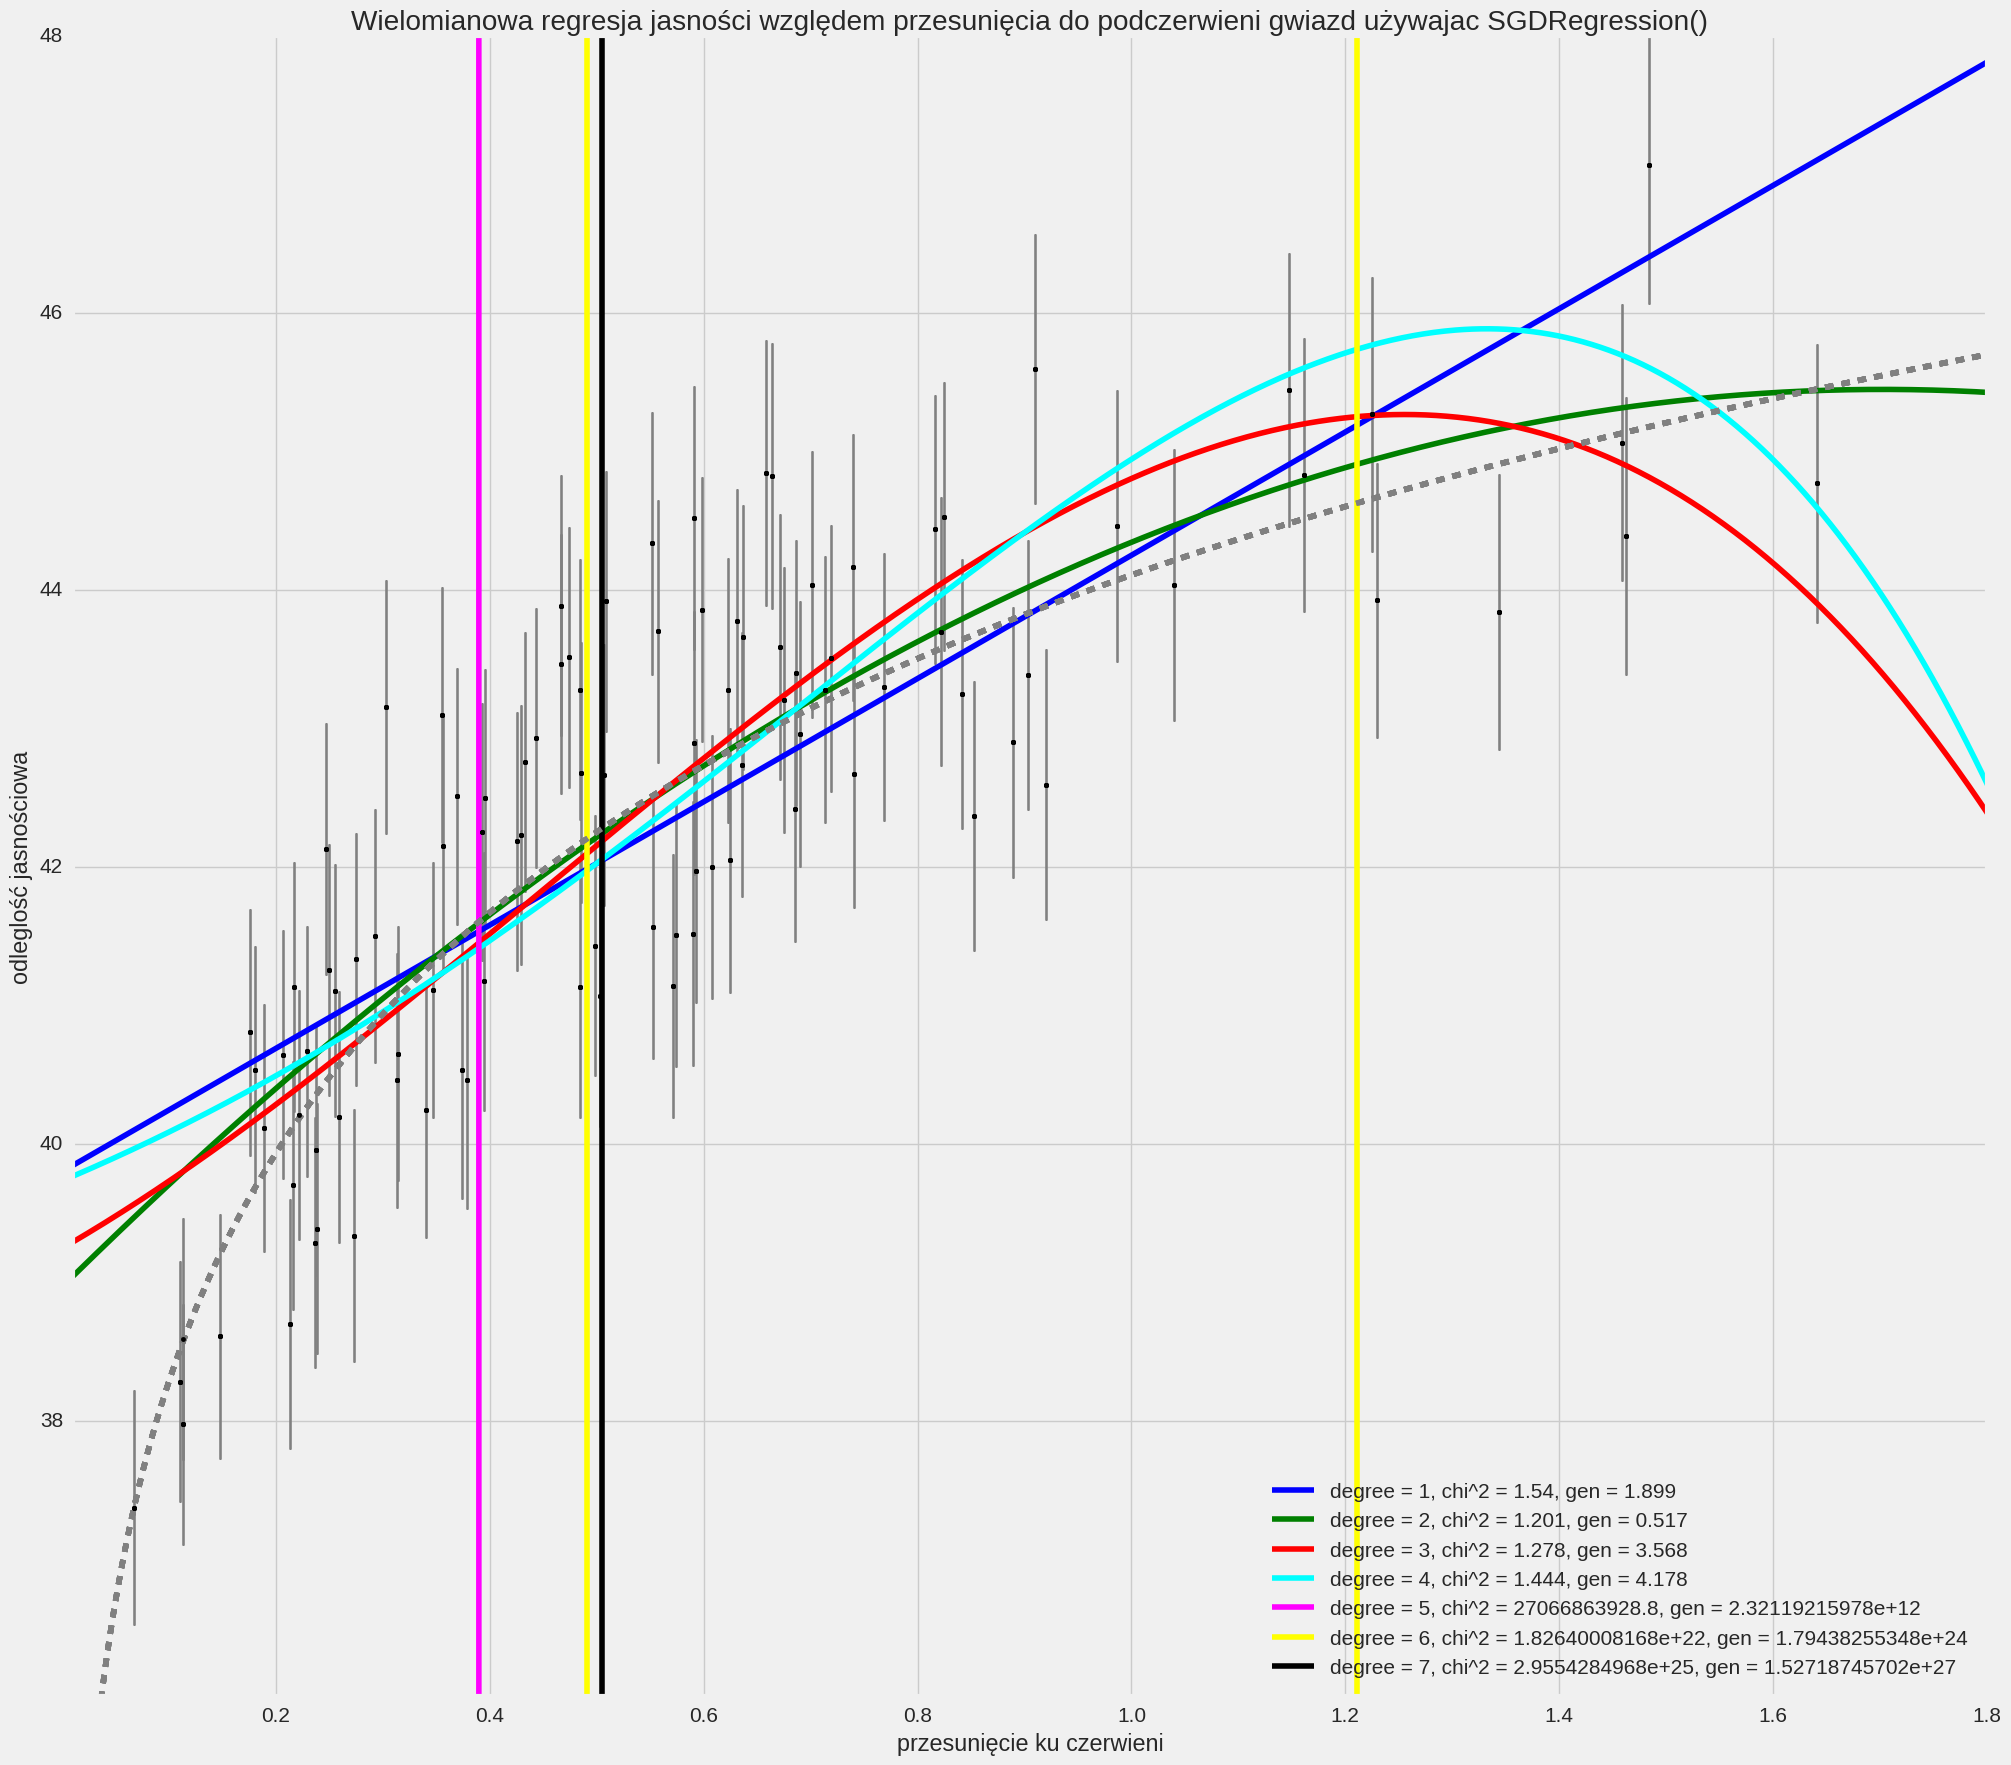

In [47]:
cosmo_poly(n_examples=100, degree_list=[1, 2, 3, 4, 5, 6, 7], 
      classifier='sgd', loss='squared_loss',
      scalecenter=True, penalty='none')

   1: coef: [ 0.     1.753]
   2: coef: [ 0.     2.991 -0.889]
   3: coef: [ 0.     1.775  1.719 -1.028]
   4: coef: [ 0.     1.17   1.009  0.519 -0.462]
   5: coef: [        0.     30723626.664  53282145.846   -312488.86  -88548517.992
  27094469.986]
   6: coef: [  0.000e+00  -2.258e+09   4.759e+09   4.110e+09  -2.629e+09   9.044e+08
   8.592e+10]
   7: coef: [  0.000e+00   1.209e+10   1.230e+10   1.028e+10   8.660e+09   1.146e+10
   2.236e+10   3.269e+10]


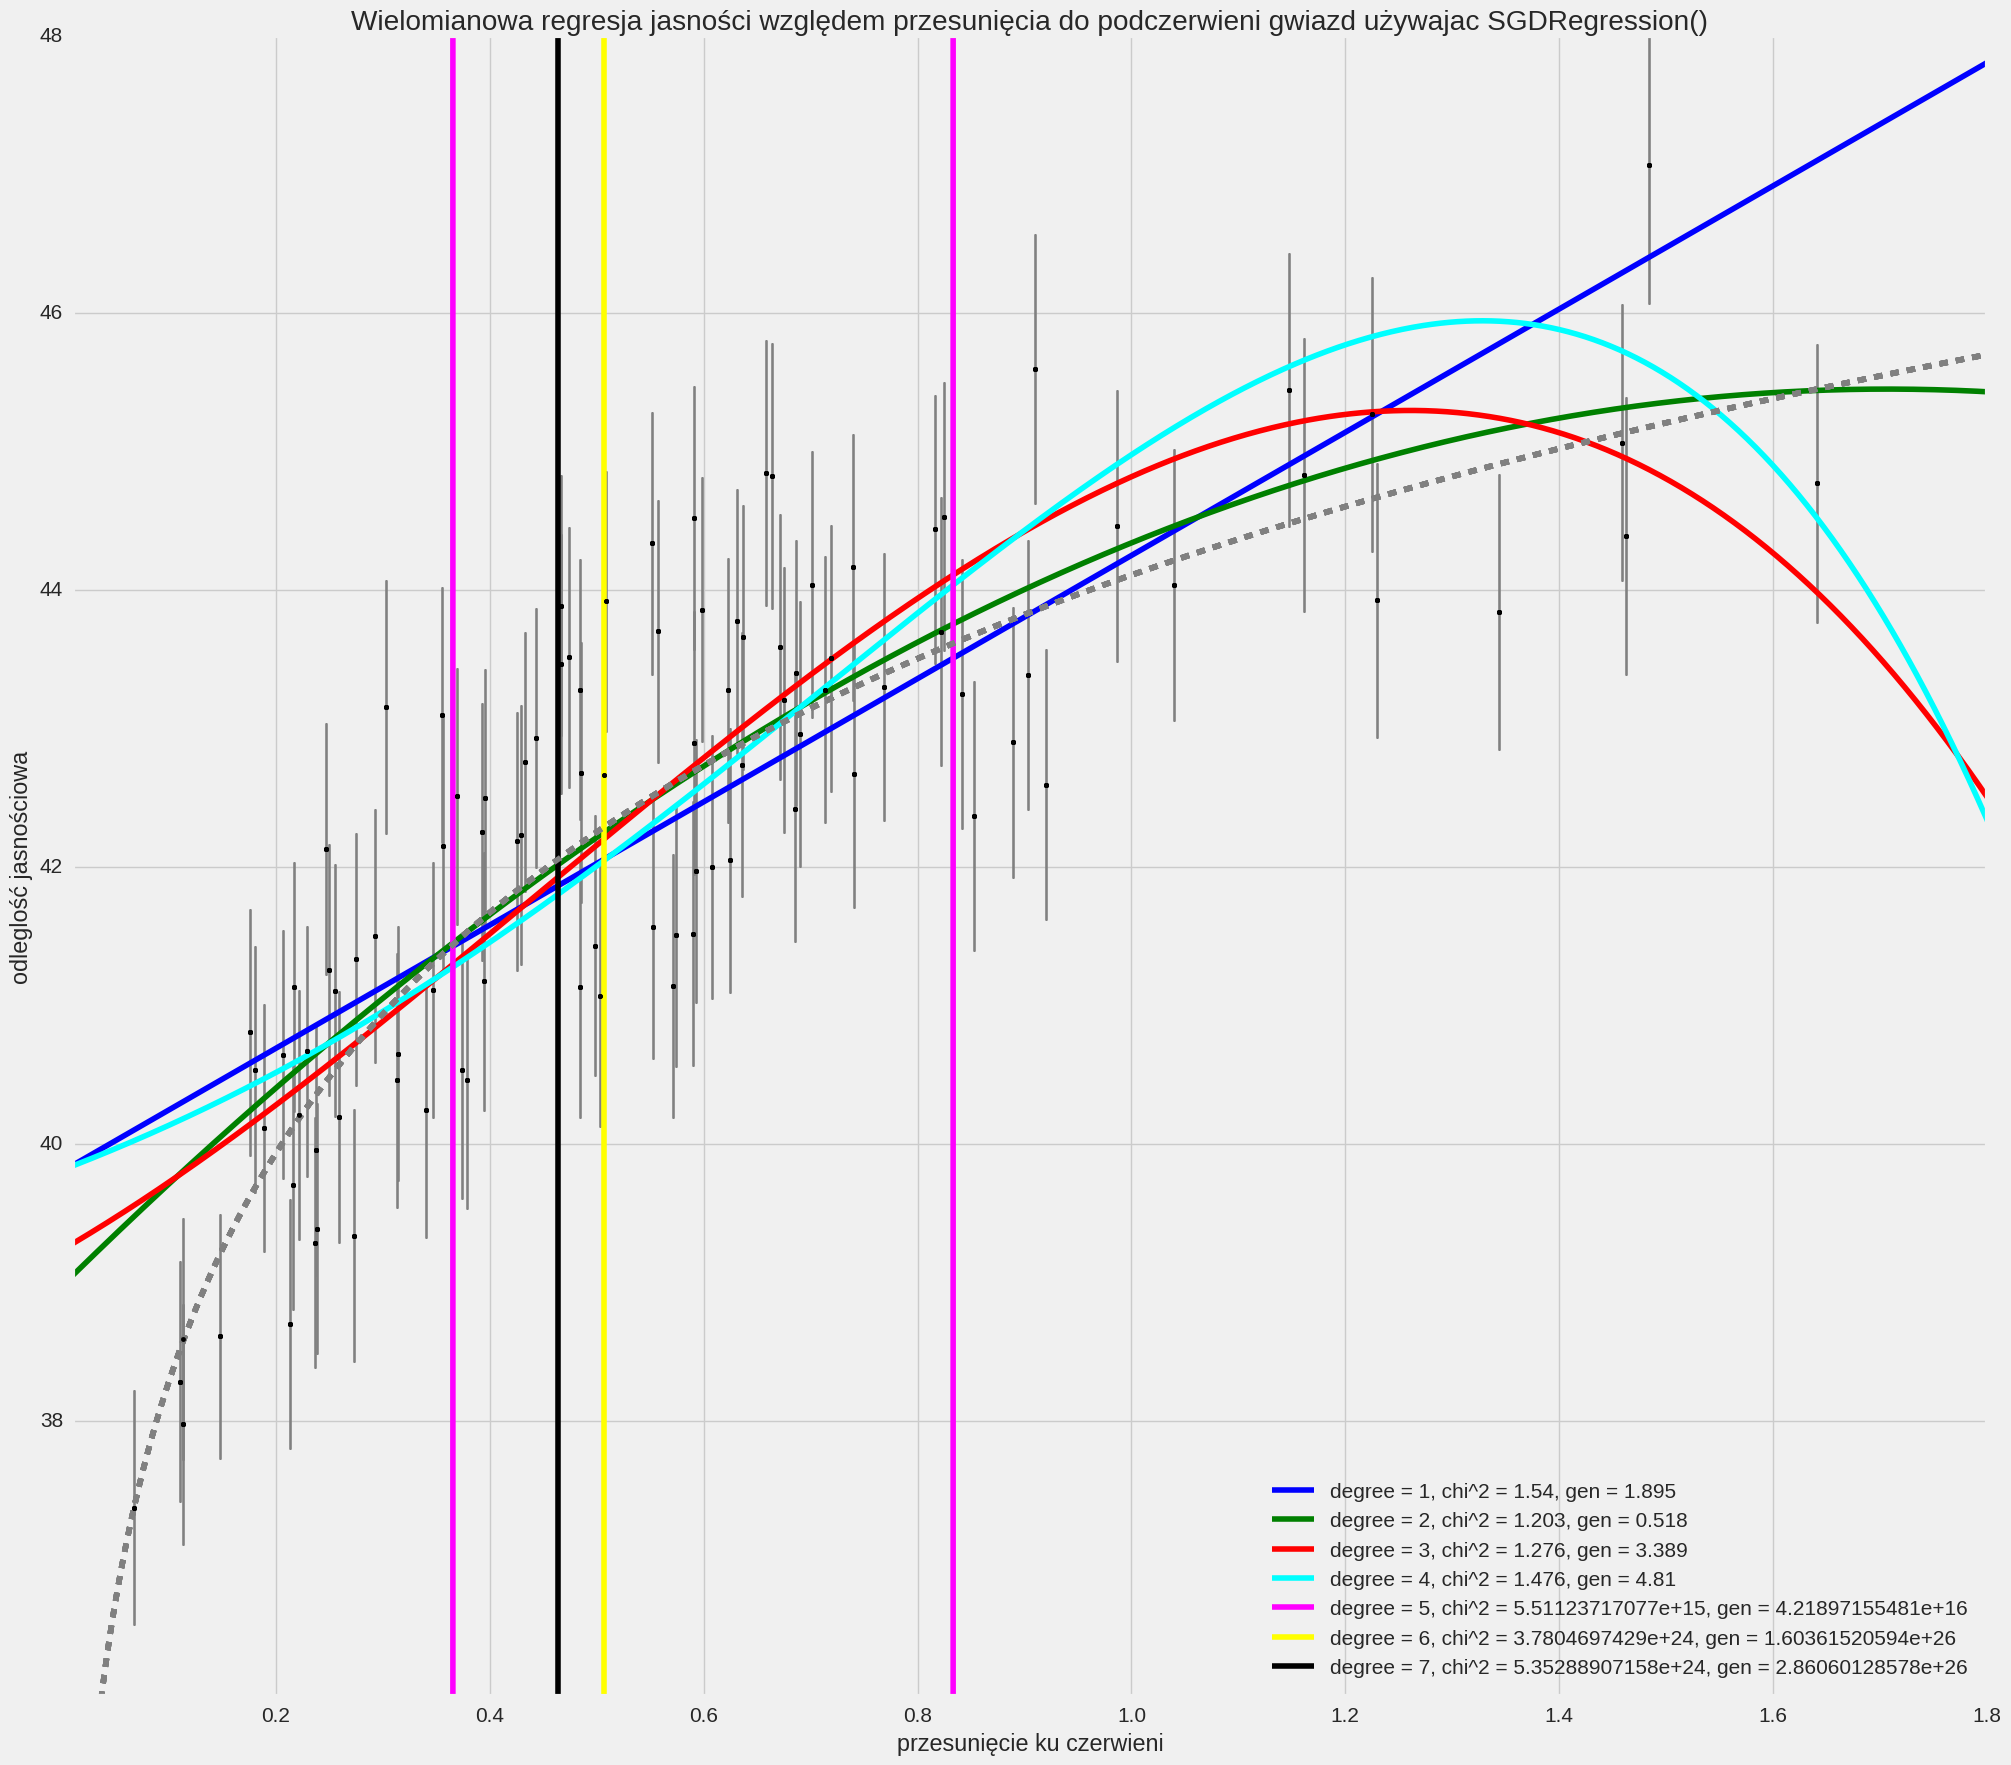

In [48]:
cosmo_poly(n_examples=100, degree_list=[1, 2, 3, 4, 5, 6, 7], 
      classifier='sgd', loss='squared_loss',
      scalecenter=True, penalty='l2')

   1: coef: [ 0.     1.754]
   2: coef: [ 0.     2.995 -0.889]
   3: coef: [ 0.     1.737  1.776 -1.046]
   4: coef: [ 0.     1.101  1.017  0.602 -0.499]
   5: coef: [  0.000e+00   1.562e+08   2.280e+08  -3.800e+07  -3.583e+08   1.203e+08]
   6: coef: [  0.000e+00  -1.010e+10  -9.917e+09  -1.236e+10  -1.772e+10  -2.470e+10
  -2.379e+10]
   7: coef: [  0.000e+00  -5.576e+09   4.974e+08   4.162e+09   6.297e+09   7.563e+09
   6.429e+09  -1.145e+10]


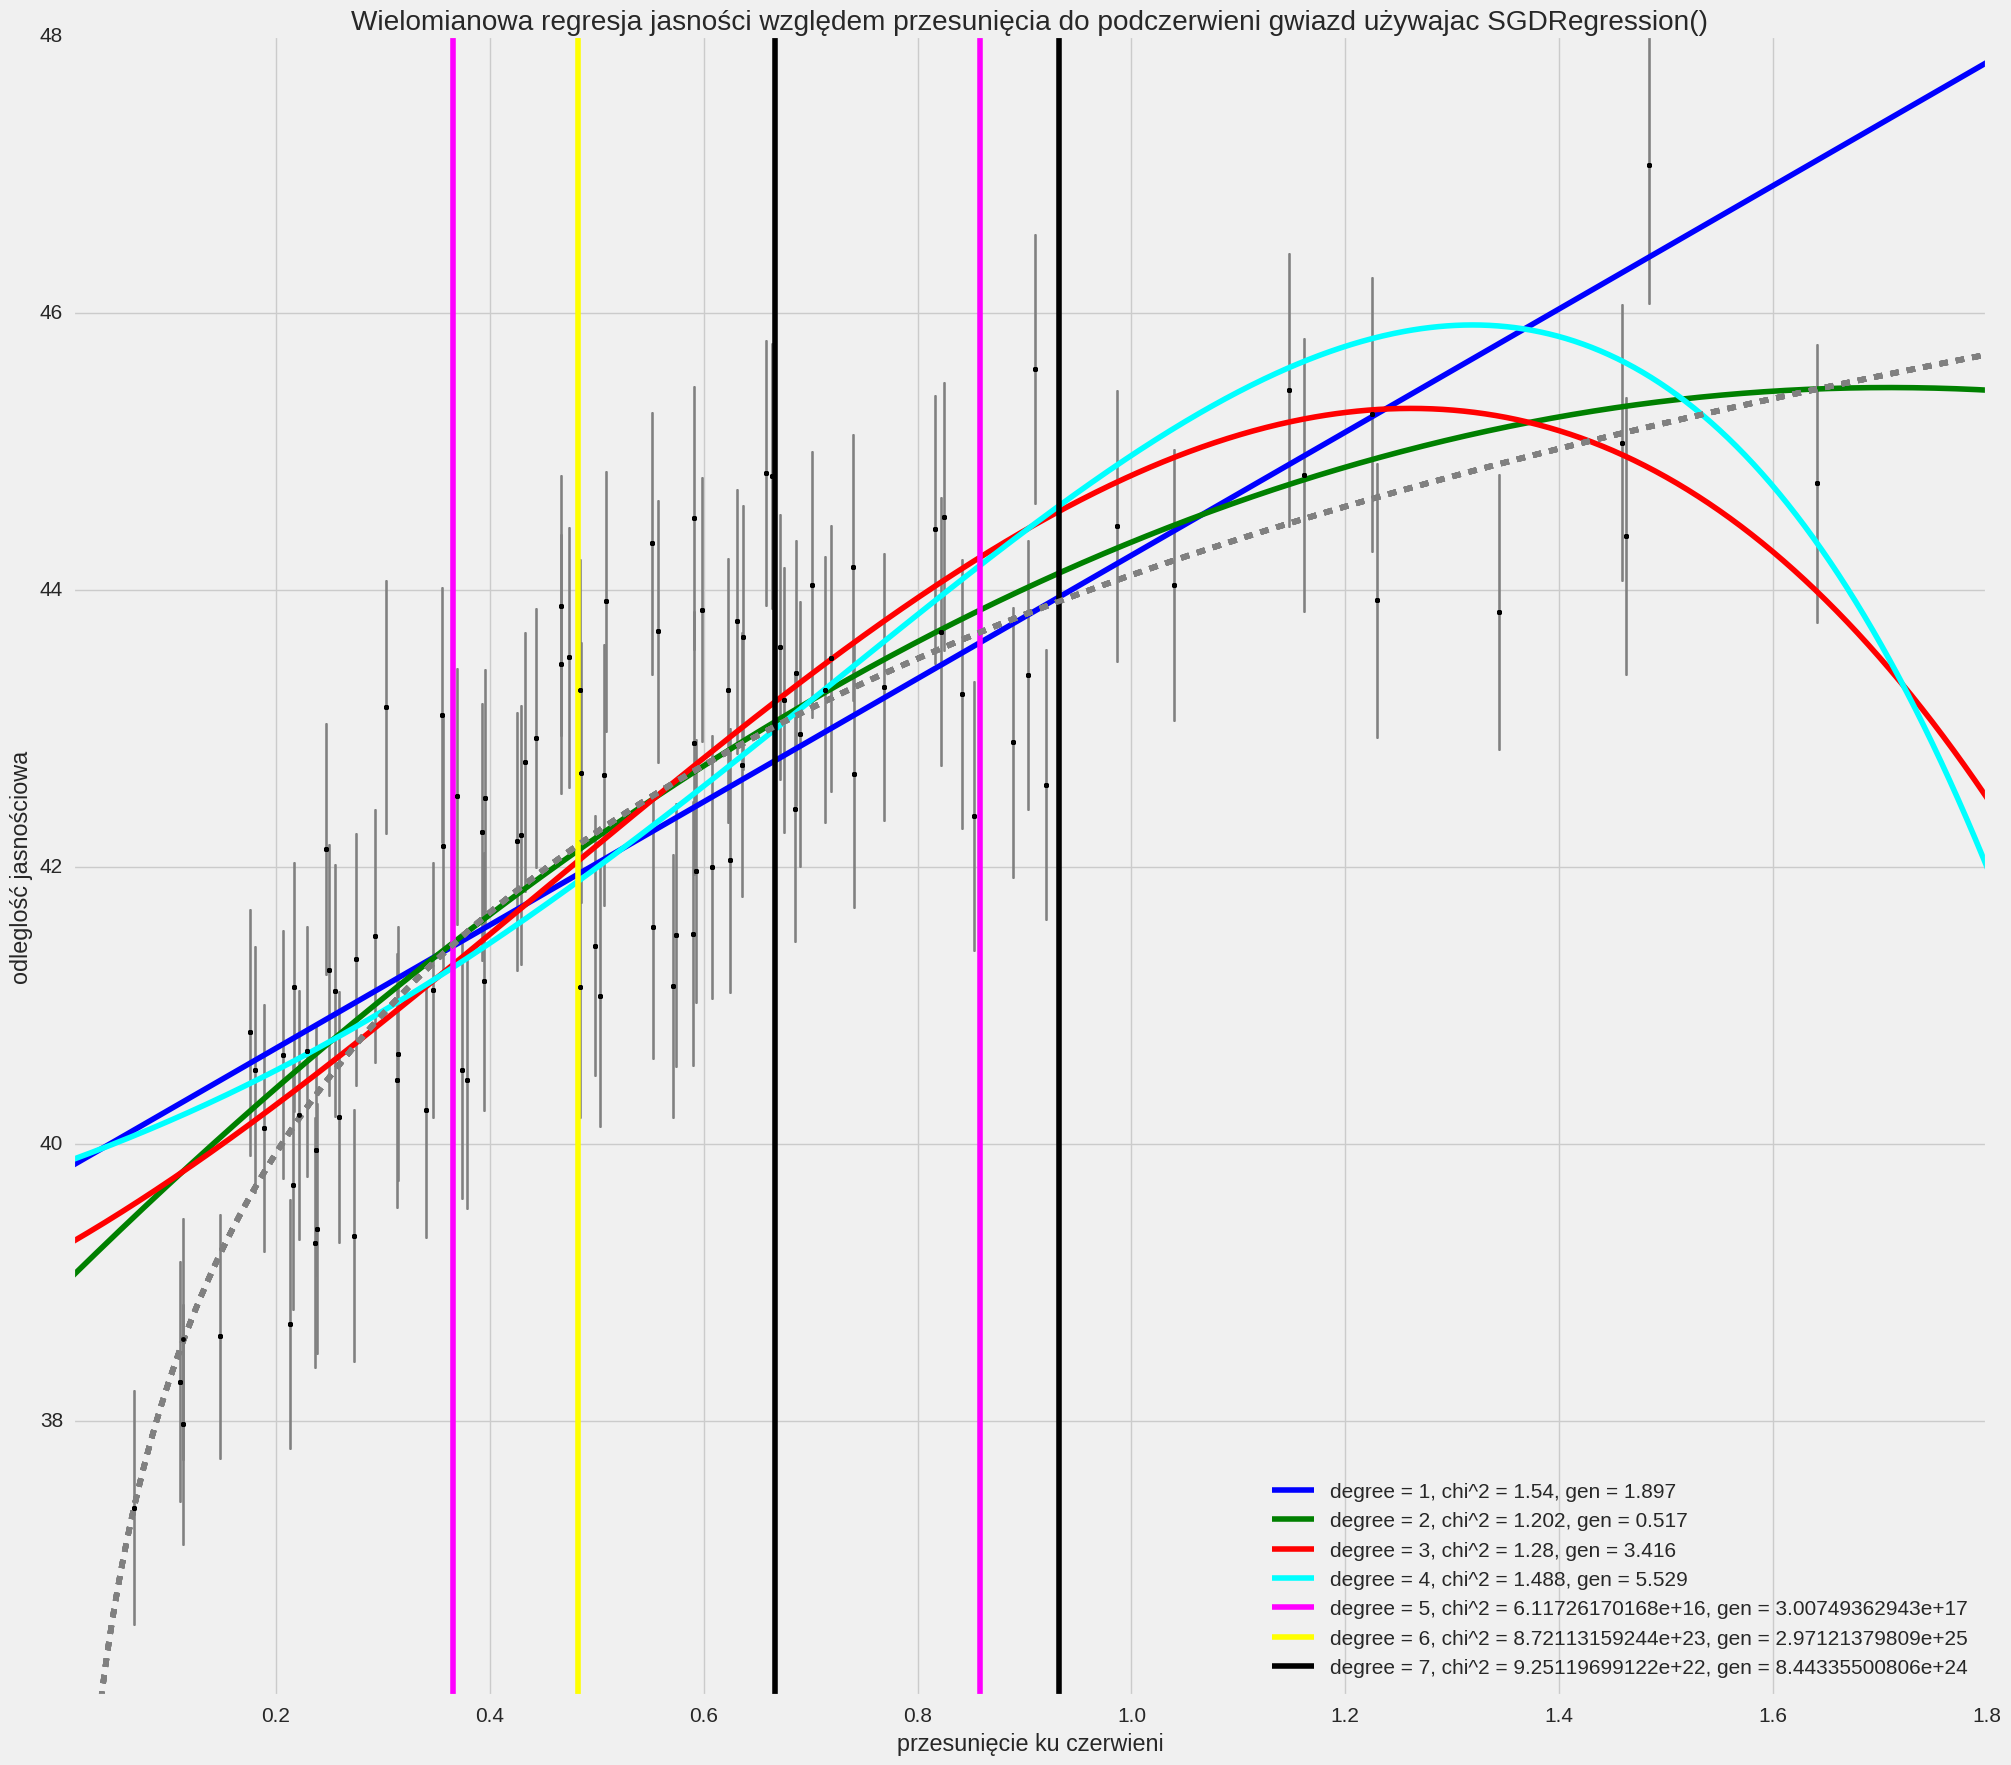

In [49]:
cosmo_poly(n_examples=100, degree_list=[1, 2, 3, 4, 5, 6, 7], 
      classifier='sgd', loss='squared_loss',
      scalecenter=True, penalty='l1')

# Metoda stochastycznego spadku gradientu


* rozwiązywanie równań Wienera-Hopfa dla MSE __wymaga znajomości statystyk procesu__ dla uzyskania macierzy korelacji $\mathbb{E}[xx^T]$ i kowariancji $\mathbb{E}[xy]$
  * zwykle niedostępne
  * dostępne tylko przykłady uczące
* rozwiązaniem mogą być metody _online_ modyfikujące rozwiązanie przy każdym nowym przykładzie
  * uczenie następuje w sposób __iteracyjny__
  * są proste obliczeniowo
  * mają zdolność _adaptacji_ do _wolno_ zmieniających się procesów (stąd _metody adaptacyjne_)
  * są przydatne dla dużych problemów ponieważ dane __nie muszą__ być dostępne __jednocześnie__
  * rozwiązanie układu równań dla znalezienia $\theta_\ast$ poprzez $$\theta=(X^TX)^{-1}X^Ty$$ wymaga __odwrócenia__ macierzy $X^TX$, co jest bardzo złożone obliczeniowo
    * problem może być źle uwarunkowany

## Metoda spadku gradientu

* iteracyjna metoda minimalizacji funkcji kosztu $L(\theta),\;\theta\in\mathbb{R}^p$
  * rozpoczynając od $\theta^{(0)}$ 
  $$\boxed{\theta^{(i)}=\theta^{(i-1)}+\mu_i\Delta\theta^{(i)}\;}$$
  * wszystkie metody spadku gradientu mają taką postać różniąc się wyborem kroku $\mu_i$ oraz sposobem obliczania $\Delta\theta^{(i)}$
    * $L()$ __musi być różniczkowalna__!
  * spadek gradientu wybiera takie $\Delta\theta^{(i)}$ aby 
  $$L(\theta^{(i)})<L(\theta^{(i-1)})$$
* wykorzystując, jak zawsze, rozwinięcie w szereg Taylora
$$\begin{align}
L(\theta^{(i)})&=L(\theta^{(i-1)}+\mu_i\Delta\theta^{(i)})\\
&\simeq L(\theta^{(i-1)})+\mu_i\nabla^TL(\theta^{(i-1)})\Delta\theta^{(i)}
\end{align}$$
  * wystarczy teraz wybrać taką modyfikację, aby $$\nabla^TL(\theta^{(i-1)})\Delta\theta^{(i)}<0$$
    * to odpowiada rozwartemu kątowi między $\nabla\theta^{(i-1)}$ a $\Delta\theta^{(i)}$
    <img src="../mum_figures/steepestdescent.png" width="95%"/>
    * wektor gradientu $\nabla L(\theta^{(i)})$ jest ortogonalny do płaszczyzny stycznej do krzywej o równych wartościch funkcji kosztu w miejscu $\theta^{(i)}$
    * kąt między gradientem a poprawką $\Delta\theta^{(i)}$ jest __rozwarty__ (taki kierunek poprawki jest wybrany na rysunku)
  * jeśli wartość $\mu_i\|\Delta\theta^{(i)}\|$ będzie __zbyt duża__, to nowa wartość $\theta^{(i)}$ może znaleźć się po _drugiej stronie krzywizny_
    * rozwinięcie Taylora będzie prawdziwe tylko dla małych rozwinięć

### Tryby metody spadku gradientu

* __batch__: dla danego $\theta^{(i-1)}$
  * dla wszystkich przykładów $x_n$ obliczyć wartość wynikającej z nich poprawki $\Delta\theta^{(i)}(x_n)$
  * poprawki uśrednić i obliczyć nowe $\theta^{(i)}$
  * metoda dokładna ale powolna, szczególnie dla dużych zbiorów danych
* __przykład po przykładzie (stochastyczny)__: dla $\theta^{(i-1)}$
  * wylosować przykład $x_n$
    * zwykle przykłady brane są po kolei, ale wcześniej pomieszane by uniknąć schematów w zbiorze danych
  * obliczyć $\Delta\theta^{(i-1)}(x_n)$ i zmodyfikować $\theta^{(i-1)}$
  * mniej dokładna ale
    * poprawka dla losowego przykładu zwykle zmierza w prawie tym samym kierunku co obliczona dla całego zbioru przykładów
    * to znacznie przyspiesza uczenie
    * są jednak pewne niedokładności i możliwość meandrowania
* __mini_batch__
  * zbiór uczący podzielić na małe podzbiory przykładów, zwykle $10-20$
  * zaaplikować podejście batdch _ale_ do kolejnych mini-batchy
  * lepsze uśrednienie kierunku poprawy
  * podejście optymalne

In [50]:
def stochastic_gradient_regression():
    # SGDRegressor jest metodą stochastycznego spadku gradientu
    fig, ax = plt.subplots(1, 3, figsize=(24, 12))
    n_samples = 500
    bias = 10.0
    X, y, true_coef = make_regression(n_samples=n_samples, n_features=1, n_targets=1, bias=bias, noise=10.0, coef=True)
    for i in range(2): ax[i].set_xlabel('x'); ax[i].set_ylabel('y')
    for i in range(2): ax[i].set_xlim((np.min(X), np.max(X))); ax[i].set_ylim([np.min(y), np.max(y)])

    regr = SGDRegressor(loss='squared_loss', penalty='none', n_iter=100, verbose=0)
    regr.fit(X, y)
    print("Cały zbiór uczący")
    print("\ttrue/znalezione wsp.: {}/{}, bias = {}".format(true_coef, regr.coef_, bias))
    print("\tresidual error =", np.mean((regr.predict(X) - y) ** 2))
    print("\tscore =", regr.score(X, y))
    ax[0].scatter(X, y, color='black')
    ax[0].plot(X, regr.predict(X), color='blue', linewidth=1)
    ax[0].set_title('Stochastic gradient descent na całych danych')
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    regr.fit(X_train, y_train)
    print("train/test model")
    print("\ttrue/znalezione wsp.: {}/{}, bias = {}".format(true_coef, regr.coef_, bias))
    print("\tresidual error =", np.mean((regr.predict(X_test) - y_test) ** 2))
    print("\tscore =", regr.score(X, y))
    ax[1].scatter(X_train, y_train, color='black')
    ax[1].scatter(X_test, y_test, color='red')
    ax[1].plot(X, regr.predict(X), color='blue', linewidth=1)
    ax[1].set_title("Stochastic gradient descent na train/test split danych")

    # ewaluacja wyników przez walidację krzyżową
    pred = cross_val_predict(regr, X, y, cv=10)
    ax[2].set_xlim([np.min(y), np.max(y)])
    ax[2].set_ylim([np.min(y), np.max(y)])
    ax[2].plot([y.min(), y.max()], [y.min(), y.max()], lw=1)
    ax[2].scatter(y, pred)
    ax[2].set_title("Stochastic gradient descent z walidacja krzyżowa")
    
    for i in range(3):
        ax[i].set_xlabel("Prawdziwe wartości")
    ax[0].set_ylabel("Przewidziane")

    fig.tight_layout()

Cały zbiór uczący
	true/znalezione wsp.: 0.710429478091/[ 0.902], bias = 10.0
	residual error = 99.7883301699
	score = 0.0070803345383
train/test model
	true/znalezione wsp.: 0.710429478091/[ 0.651], bias = 10.0
	residual error = 89.7458019572
	score = 0.00651569608022


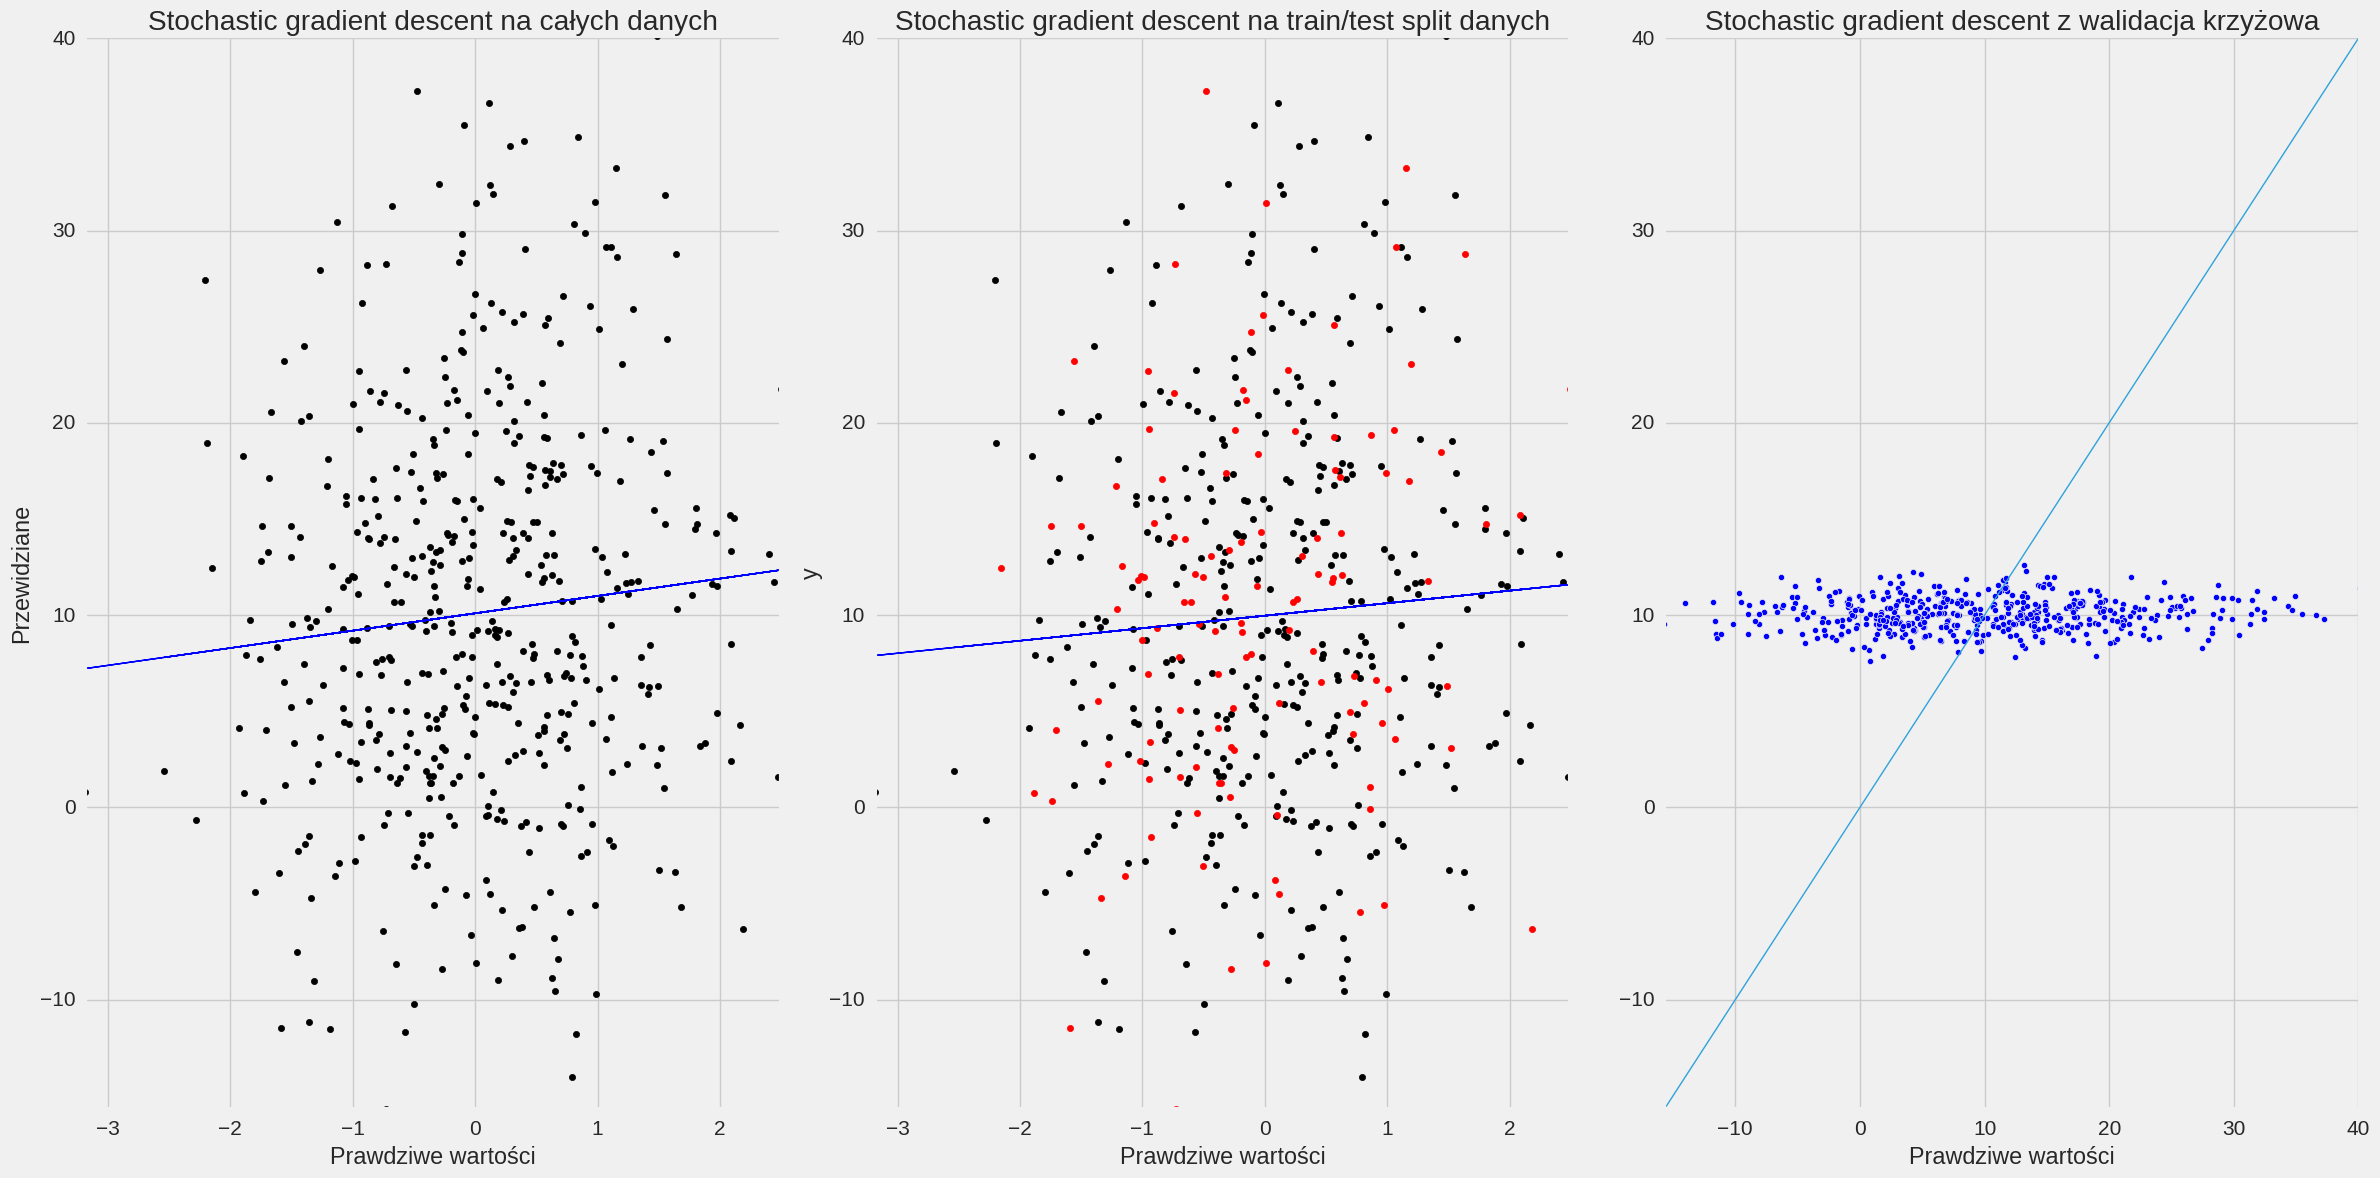

In [51]:
stochastic_gradient_regression()

In [2]:
def draw_mu_dependent_mse(lmbd = 0.25, eps = 0.10, steps=30):
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    v0 = 1.
    steps = 25
    mu_vals = [0.1, 0.5, 1.0, (1. / lmbd), (1.1 / lmbd - eps)]
    colors = ['red', 'blue', 'magenta', 'violet', 'black']
    for mu, col in zip(mu_vals, colors):
        ax.plot(range(steps), [v0 * (1. - mu * lmbd) ** i for i in range(steps)],
                color=col, label=r"$\mu$ = {}".format(mu))

    for mu, col in zip(mu_vals, colors):
        tau = 1 / (mu * lmbd)
        xx = np.linspace(0, steps, 100)
        ax.plot(xx, [np.exp(-float(i) / tau) ** i for i in xx], 
                c=col, ls='--', label=r"$\exp(-t/\tau), \tau$={}".format(tau))
    ax.legend(loc='best')

## Maximum likelihood

* wartość poszukiwana $y$ jest dana przez 
$$\boxed{y=y(x;\theta)+\eta=\hat{y}+\eta\;}$$
gdzie $\eta$ jest szumem o zerowej wartości średniej i wariancji $\sigma$
* prawdopodobieństwo warunkowe $y$
$$p(y|x, w, \sigma)=\mathcal{N}(y|y(x;\theta),\sigma)$$
  
* optymalnym rozwiązaniem jest wartość oczekiwana $$\mathbb{E}[y|x]=\int y p(y|x) dy = y(x;\theta)$$
  
  
* niech dany będzie zbiór uczący $$\{(x_k,y_k)\}_{k=1}^N\subset{}X\times{}Y$$ ($x_k$ jest tu $k$-tym przykładem) 
* ponieważ przykłady są wylosowane _niezależnie_, to można zdefiniować __funkcję liklihood__
$$p(Y|X,\theta,\sigma)=\prod_{k=1}^N \mathcal{N}(y_k|\theta^T\phi(x_k), \sigma)$$
gdzie
$$\mathcal{N}(y_k|\theta^T\psi(x_k),\sigma^2)=\frac{1}{(2\pi\sigma^2)^{1/2}}\exp\left(\frac{1}{2\sigma^2}(y_k-\theta^T\psi(x_k))^2\right)
$$
  
* biorąc __logarytm__ uzyskujemy funkcję __log-likelihood__ i zamieniamy iloczyn na sumę!
$$\begin{align}
\ln p(y|\theta,\sigma)&=\sum_{k=1}^N\ln\mathcal{N}(y_k|\theta^T\phi(x_k),\sigma)\\
&=-\frac{N}{2}\ln\sigma^2-\frac{N}{2}\ln(2\pi)-\frac{\sigma^2}{2}\sum_{k=1}^N\left(y_k-\theta^T\phi(x_k)\right)^2
\end{align}$$
  * pierwsze dwa składniki są stałe (dla danego zbioru uczącego)
  * maksymalizacja likelihood oznacza _minimalizację_ sumy kwadratów
  * gradient funkcji likelihood jest przyrównywany do zera
  $$\begin{align}
  %\nabla\ln p(y|\theta,\sigma)&=\sum_{k=1}^N\left(y_k-\theta^T\phi(x_k)\right)\phi(x_k)^T\\
  0=\nabla\ln p(y|\theta,\sigma)&=\sum_{k=1}^N\left(y_k-\theta^T\phi(x_k)\right)\phi(x_k)^T\\
  &=\sum_{k=1}^Ny_k\phi(x_k)^T-\theta^T\left(\sum_{k=1}^N\phi(x_k)\phi(x_k)^T\right)
  \end{align}$$
  
  
  * to daje rozwiązanie __problemu najmniejszych kwadratów__ $$\boxed{\;\hat\theta=(\Phi^T\Phi)^{-1}\Phi^Ty\;}$$
  gdzie $$\Phi=\begin{pmatrix}
  \phi_{1}(x_{1}) & \phi_{2}(x_{1}) & \cdots & \phi_{M}(x_{1}) \\
  \phi_{1}(x_{2}) & \phi_{2}(x_{2}) & \cdots & \phi_{M}(x_{2}) \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \phi_{1}(x_{N}) & \phi_{2}(x_{N}) & \cdots & \phi_{M}(x_{N}) 
 \end{pmatrix}$$
 
 
 * macierz $$\Phi^\dagger=(\Phi^T\Phi)^{-1}\Phi^T$$ jest zwana __macierzą Moora-Penrose'a__
   * uogólnienie macierzy odwrotnej dla macierzy nie kwadratowych
   * dla odwracalnej macierzy kwadratowej $\Phi^\dagger=\Phi^{-1}$
   
   ---
   
   > __PROBLEM__:
   
   > W rozważaniach powyżej znalezione zostały $\theta_j$ dla wszystkich funkcji bazowych $\phi_j$. Jednak dla $j=0$
   mamy z definicji $\phi_0()=1$.
   
   > Jaka jest wartość $\theta_0$? Czemu odpowiada? Jak ją zinterpretować?
   
   >Wskazówka: powtórzyć liczenie pochodnej ze składnikiem $\theta_0$ podanym _explicite_ i zminimalizować ze względu na $\theta_0$
   
   
  * parametr $\sigma$ jest odpowiedzialny za precyzję rozwiązania
  * jego optymalizacja daje $$\hat\sigma=\frac{1}{N}\sum_{k=1}^N\left(y_k-\hat\theta^T\phi(x_k)\right)^2$$

In [54]:
def compare_regressors():
    n_samples = 200 
    # data = make_friedman1(n_samples=n_samples)              ## koduje targety z wykorzystaniem wielomianów i sinusa (10 --> 1)
    # X, y = make_friedman2(n_samples=n_samples)              ## używa mnożenia i dzielenia cech wejsciowych (4 --> 1)
    # X, y = make_friedman3(n_samples=n_samples)              ## arctan na targecie (4 --> 1)
    X, y = make_sparse_uncorrelated(n_samples=n_samples)    ## liniowa kombinacja czterech wejść (4 --> 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    fig, ax = plt.subplots(1, 2, figsize=(18, 9))

    names = ['LinearRegression()', 'SGDRegressor()']
    regressors = [LinearRegression(), SGDRegressor(loss='squared_loss', penalty='none', n_iter=500)]
    for k, lr in enumerate(regressors):
        predicted = cross_val_predict(lr, X, y, cv=10)
        score = mean_squared_error(y, predicted)
        ax[k].set_title(names[k])
        ax[k].set_xlabel('true')
        ax[k].set_ylabel('predicted')
        ax[k].scatter(y, predicted, s=8)
        ax[k].plot([y.min(), y.max()], [y.min(), y.max()], ls='--', lw=2, label='score = {}'.format(score))
        ax[k].set_xlim([y.min(), y.max()])
        ax[k].set_ylim([y.min(), y.max()])
        ax[k].legend(loc=0)

    fig.tight_layout()


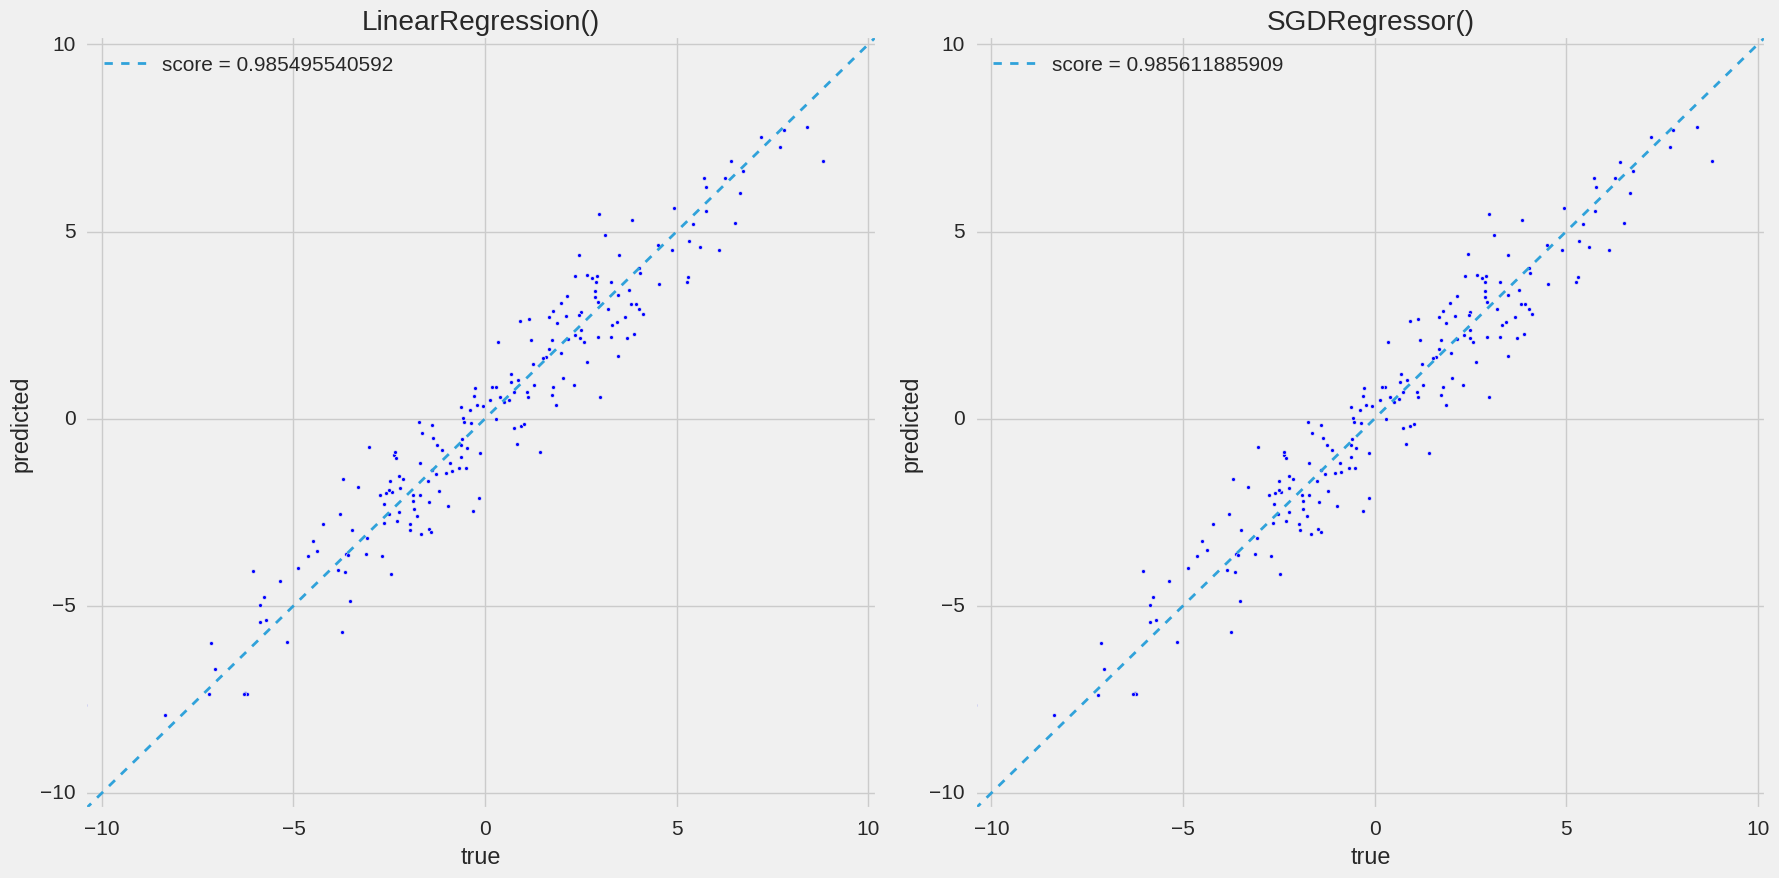

In [55]:
compare_regressors()

# Regularyzacja

## Definicja zadania
* _regularyzacja_ nakłada pewną wiedzę _a priori_ na strukturę rozwiązania
> Pierwszy raz zaproponowana przez Andrieja Nikołajewicza Tichonowa (1906-1993) 
<img src="../mum_figures/tychonoff.png" width="35%"/>
  
* inne postawienie zadania najmniejszych kwadratów
  * minimalizuj $L(\theta)=\sum_{n=1}^N\left(y_n-\theta^Tx_n\right)^2$
  * z ograniczeniem $\|\theta\|^2\leq\rho$
  
* zadanie nie ma teraz _całkowitej swobody_ w wyborze rozwiązania
* przestrzeń możliwych rozwiązań jest __ograniczona__
  
  
* znalezienie __optymalnego $\rho$__ nie jest możliwe do znalezienia analitycznie
  * potrzeba szeregu doświadczeń
  
  
* równoważne zadanie __ridge regression__ (zwane także __weight decay__ oraz regularyzacją __L2__)
$$\boxed{\hat\theta = \underset{\theta}{\arg\min}\;\;\frac{1}{2}\sum_{n=1}^N\left(y_n-\theta^Tx_n\right)^2+\lambda\|\theta\|\;}$$
  * weight decay, bo minimalizuje parametry o ile te nie są poparte danymi
  * istnieje bezpośrednia relacja miedzy $\rho$ a parametrem $\lambda$
  * im większe $\lambda$, tym silniejsze osłabianie
    * im większe $\lambda$, tym wynik regresji jest mniej zależny od rzeczywistych danych
    * wejście dla bias jest stałe
    * $\lambda_0$ związana z parametrem bias $w_0$ powinna być regulowana niezależnie
  
* przyrównując gradient $L()$ do zera otrzymujemy rozwiązanie
$$\begin{align}
\nabla{}L(\theta, \lambda)&=-\sum_n(y_n-\theta^Tx_n)x_n+\lambda\theta\\
&=-\sum_ny_nx_n +\sum_n\theta^Tx_nx_n^T+\lambda\theta=0\\
\left(\sum_nx_nx_n^T+\lambda{}I\right)\hat\theta&=\sum_ny_nx_n
\end{align}$$
regularyzowane problemu jak w [rozwiązaniu maximum likelihood](Maximum-likelihood) (tam dla uogólnionego zadania modeli liniowych)
$$\hat\theta=(X^TX+\lambda{}I)^{-1}X^Ty$$
  * takie podejście jest również rozwiązaniem problemu gdy macierz jest nieodwracalna 
    * zwiększenie szansy, że macierz będzie odwracalna było pierwszym celem wprowadzenia tego rozwiązania!
  
  
* ridge regression modyfikuje parametry $\theta_j$ tak, by minimalizować koszt rozwiązania redukując wpływ __mniej istotnych__ (ang. _less informative_) kierunków przestrzeni wejściowej
  * składnik biasu $\theta_0$ __nie powinien__ byc minimalizowany
  $$\boxed{\hat\theta = \underset{\theta}{\arg\min}\;\; \frac{1}{2}\sum_{n=1}^N\left(y_n-\theta_0-\sum_{j=1}^l\theta_ix_{ni}\right)^2+\lambda\sum_{j=1}^l\theta_j\;}$$
    * Dlaczego? Patrz rozwiązanie PROBLEMu
  * regularyzacja modelu z funkcjami bazowymi $$\sum_{j=1}^M\theta_j\phi_j(x)$$ powoduje __usunięcie__ mniej istotnych składowych i efektywnie obniża $K$
  

  
* regularyzacja jest zgodna z wymaganiem by zawsze wybierać __najprostszy model, który wystarczająco dobrze tłumaczy zjawiska__
  * __Brzytwa Ockhama__ _Nie mnóż bytów ponad konieczność_ (przypisywane Williamowi of Ockham, c. 1287-1347)
  * __Paul Dirac__ (1902-1984) _Teoria, która jest piękna matematycznie, ma większą szansę by być prawdziwa od tej brzydkiej, która dobrze pasuje do danych_ 
<div id="../mum_figures/occamdirac.png">
<img src="../mum_figures/occam.png" width="30%" /> 
<img src="../mum_figures/dirac.png" width="30%" /></div>
  

In [56]:
from sklearn.utils.extmath import randomized_svd
def singular_values(X):
    U, sigma, VT = randomized_svd(X, X.shape[1])
    return sigma

In [57]:
def compute_df(sigmas, lmbd):
    return np.sum([s ** 2 / (s ** 2 + lmbd) for s in sigmas])

In [60]:
def regression_regularization(data='sparse', n_samples=200, sss=4, 
                              penalty_mode='l2', n_iter=1000):
    np.set_printoptions(precision=3)
    if data == 'boston':
        bostondiabetes = load_boston()
        X = bostondiabetes.data
        y = bostondiabetes.target
    elif data == 'diabetes':
        bostondiabetes = load_diabetes()
        X = bostondiabetes.data
        y = bostondiabetes.target
    elif data == 'friedman1':
        X, y = make_friedman1(n_samples=n_samples)              ## koduje targety z wykorzystaniem wielomianów i sinusa (10 --> 1)
    elif data == 'friedman2':
        X, y = make_friedman2(n_samples=n_samples)              ## używa mnożenia i dzielenia cech wejsciowych (4 --> 1)
    elif data == 'friedman3':
        X, y = make_friedman3(n_samples=n_samples)              ## arctan na targecie (4 --> 1)
    elif data == 'sparse':
        X, y = make_sparse_uncorrelated(n_samples=n_samples)    ## liniowa kombinacja czterech wejść (4 --> 1)
    elif data == 'regression':
        X, y = make_regression(n_samples=n_samples, n_features=12, n_informative=6, n_targets=1, noise=2.0)
    else:
        print("Unknown dataset {}".format(data))

    # normalizacja danych i usunięcie średniej, warto sprawdzić, że bez tego NIE działa, samo centrowanie też nie!
    X = preprocessing.scale(X)
    scaler = preprocessing.StandardScaler(with_mean=True, with_std=True).fit(X)
    # scaler = preprocessing.RobustScaler().fit(X)
    X = scaler.transform(X)
    
    sigmas = singular_values(X)
    print("Singular values are {}".format(sigmas))
    fig, ax = plt.subplots(sss, sss, figsize=(20, 20))
    lambdas = np.logspace(1, -10, (sss ** 2))
    scores = []
    scores_std = []
    coefs = []
    df = []
    for i in range(sss):
        ax[sss - 1, i].set_xlabel('true')
        ax[i, 0].set_ylabel('predicted')
    for k, lmbd in enumerate(lambdas):
        lr = SGDRegressor(loss='squared_loss', penalty=penalty_mode, alpha=lmbd, n_iter=n_iter)
        predicted = cross_val_predict(lr, X, y, cv=10)
        score = mean_squared_error(y, predicted)
        scores.append(score)
        scores_std.append(np.std(score))
        i = k / sss
        j = k - sss * i
        ax[i, j].scatter(y, predicted)
        ax[i, j].plot([y.min(), y.max()], [y.min(), y.max()], ls='--', lw=2, c='red',
                      label='$\lambda$={}, score = {}'.format(np.round(lmbd, 5), np.round(score, 3)))
        ax[i, j].legend(loc=1)
        # compute coeficients
        lr.fit(X, y)
        coefs.append(lr.coef_)
        df.append(compute_df(sigmas=sigmas, lmbd=lmbd))
    min_ind = np.array(scores).argmin()
    print("Data set: {}, n_examples = {}, n_features = {}".format(data, X.shape[0], X.shape[1]))
    print("{} regularization".format(penalty_mode))
    print("\tBest score = {} obtained for regularization with lambda = {}".format(scores[min_ind], lambdas[min_ind]))
    fig.tight_layout()
    fig2, ax2 = plt.subplots(figsize=(18, 10))
    ax2.loglog()
    ax2.grid(True)
    ax2.plot(lambdas, scores)
    ax2.axvline(x=lambdas[min_ind], ls='--')
    
    fig3, ax3 = plt.subplots(figsize=(18, 10))
    ax3.semilogx()
    ax3.plot(lambdas, coefs)
    ax3.axvline(x=lambdas[min_ind], ls='--')
    ax3.set_xlabel('$\lambda$')
    ax3.set_ylabel('parametry')
    
    fig4, ax4 = plt.subplots(figsize=(18, 10))
    ax4.set_xlim([df[0] - 0.1, df[-1] + 0.1])
    #ax4.set_xlim([0, X.shape[1]])
    ax4.plot(df, coefs)
    ax4.axvline(x=df[min_ind], ls='--')
    ax4.set_xlabel('df($\lambda$)')
    ax4.set_ylabel('parametry')

Singular values are [ 55.66   26.919  25.06   20.834  20.55   18.27   16.515  14.165  11.848
  10.557   9.706   9.252   5.669]
Data set: boston, n_examples = 506, n_features = 13
l2 regularization
	Best score = 31.6475702707 obtained for regularization with lambda = 0.341454887383


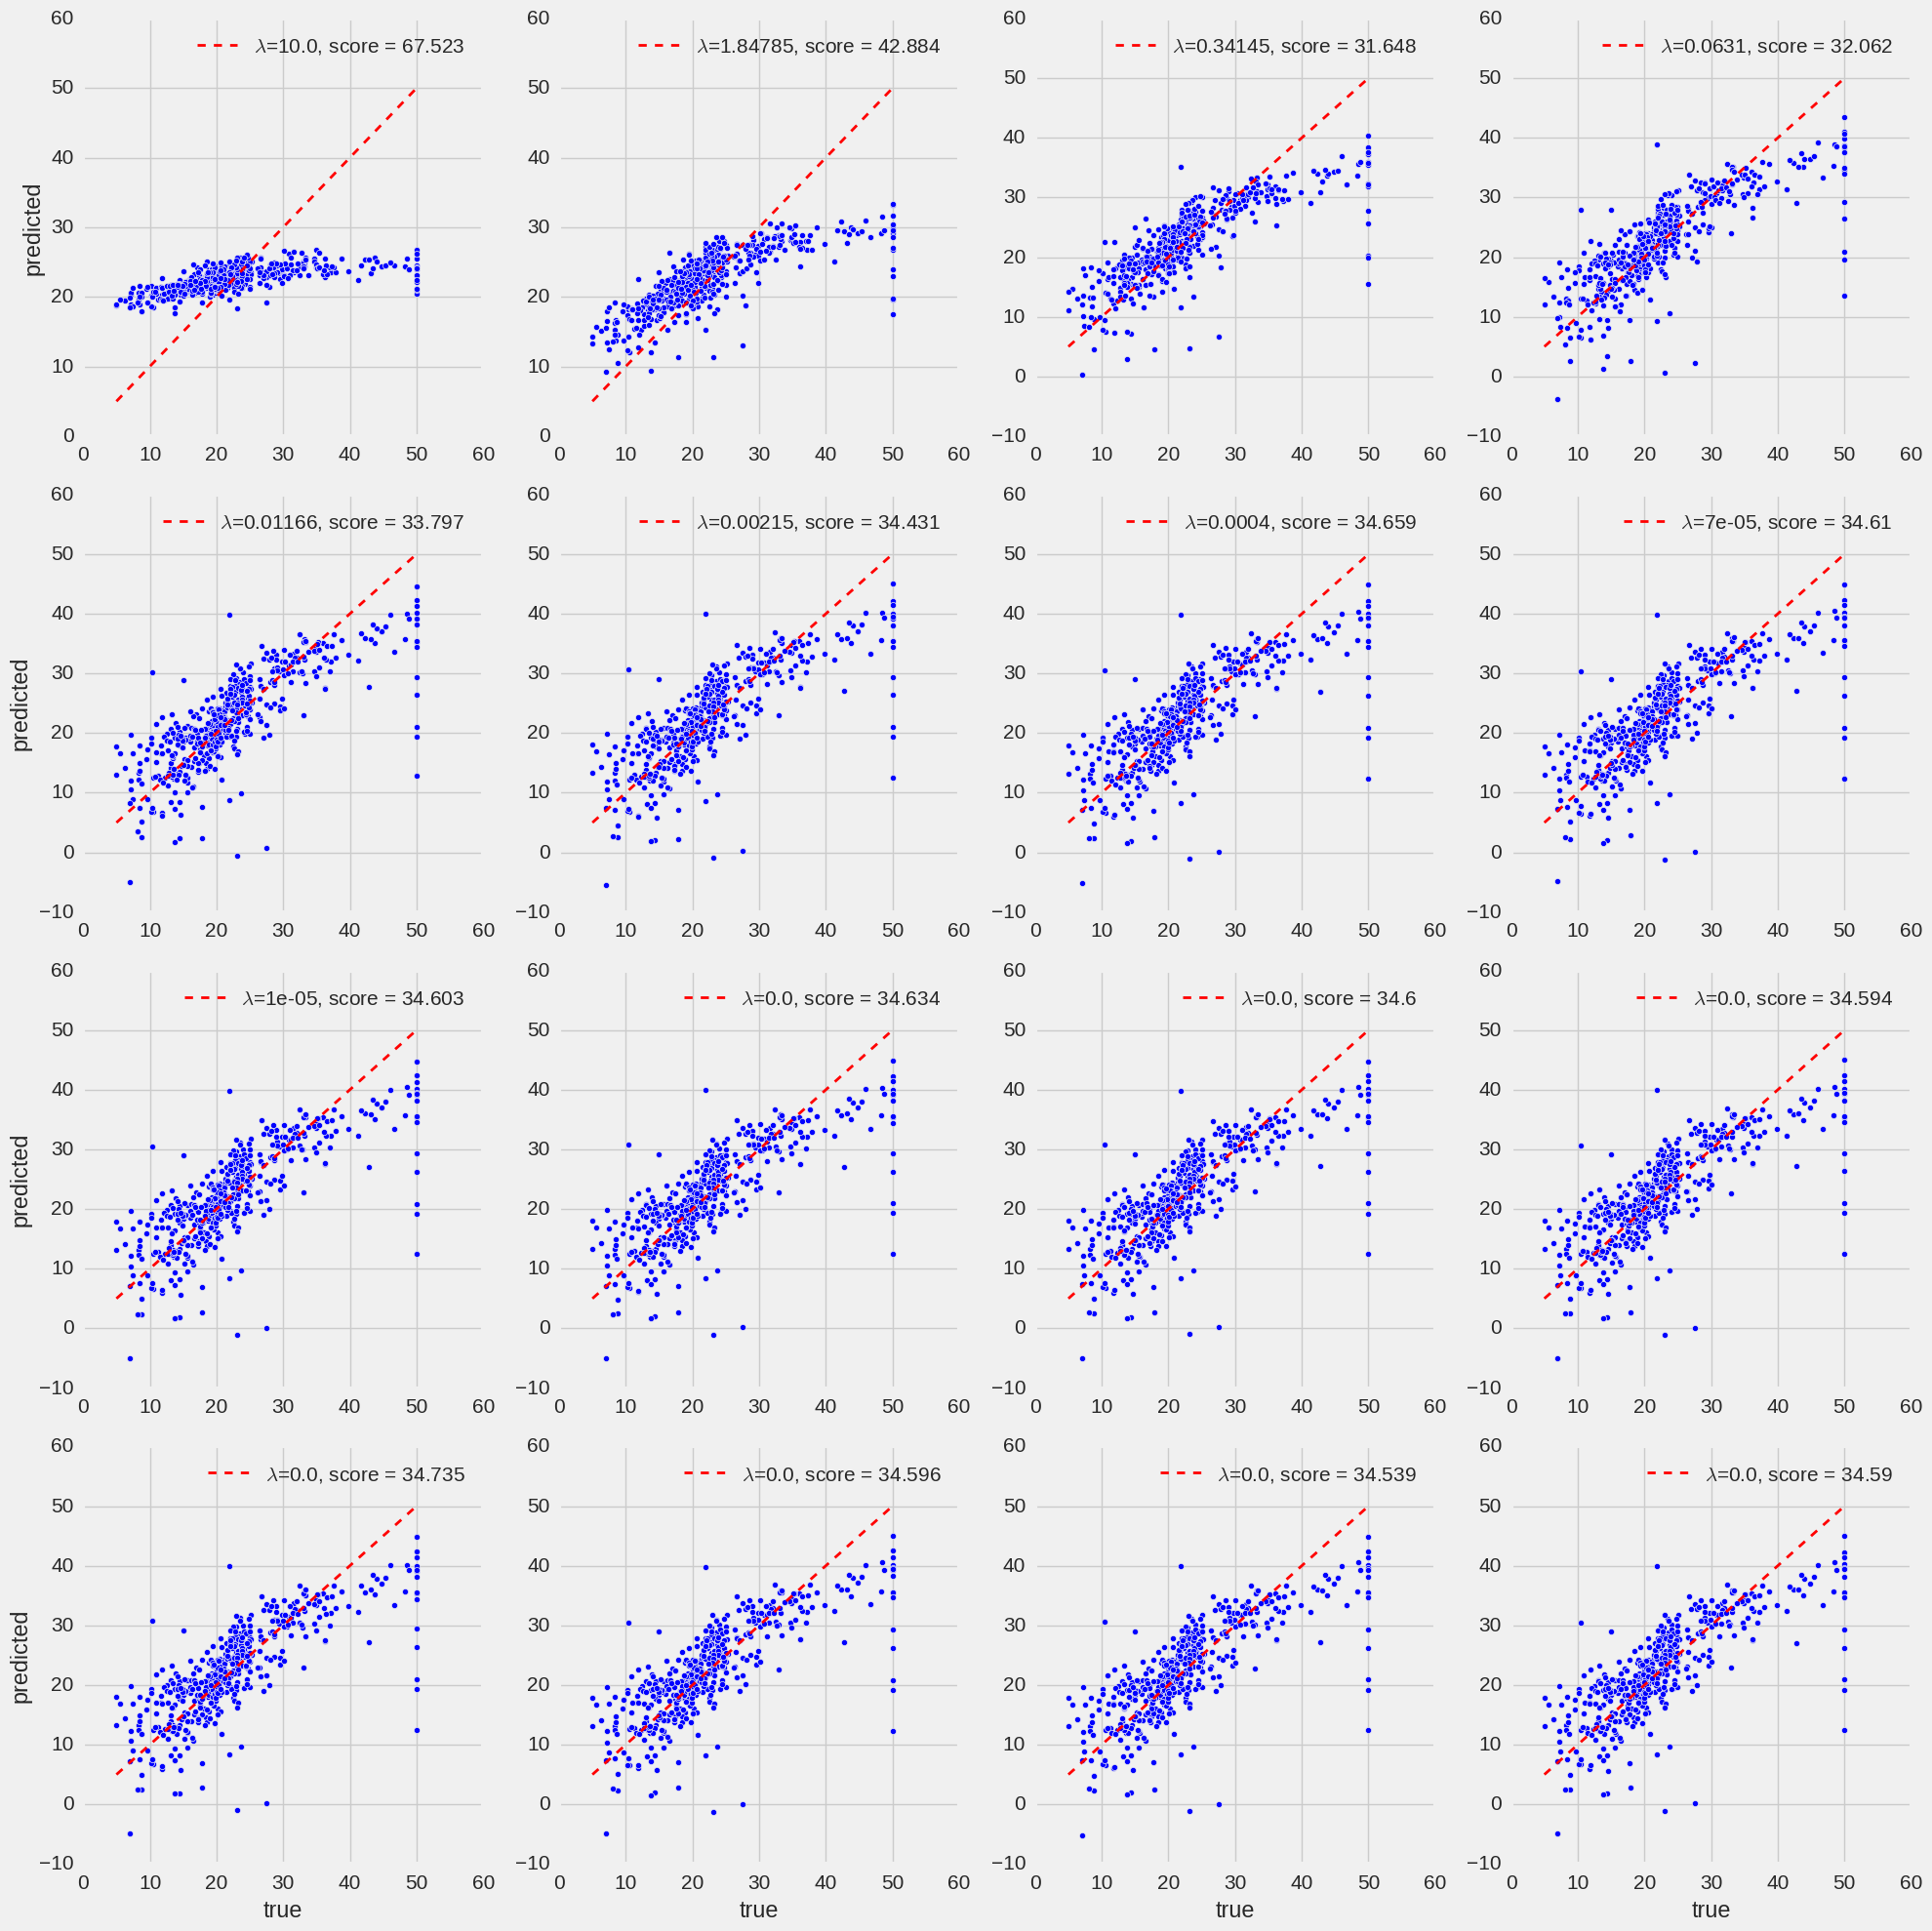

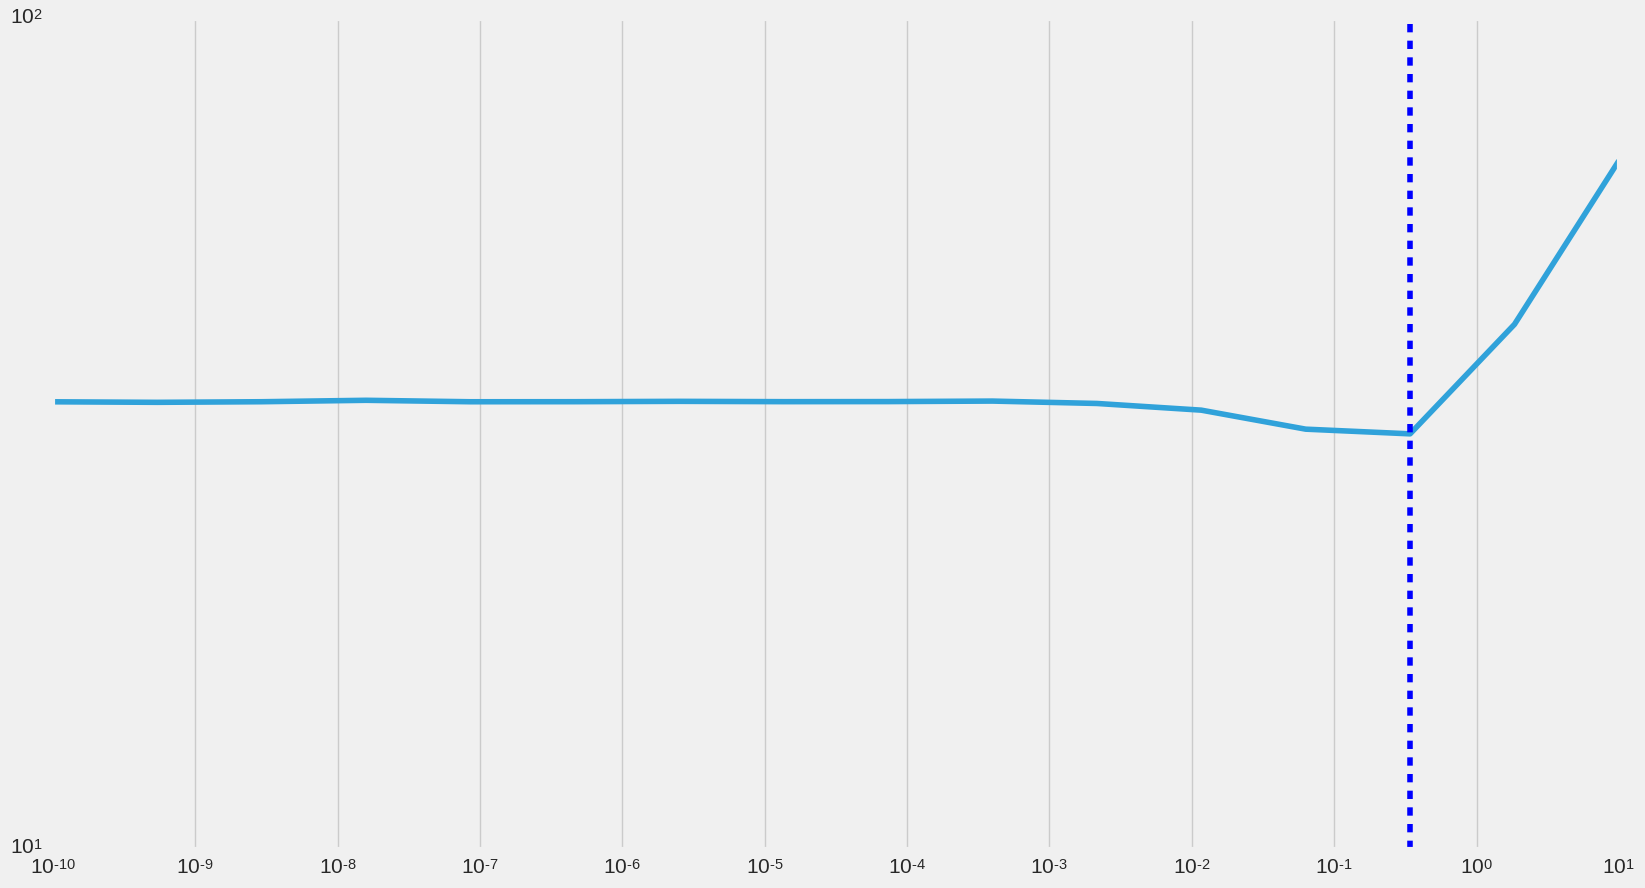

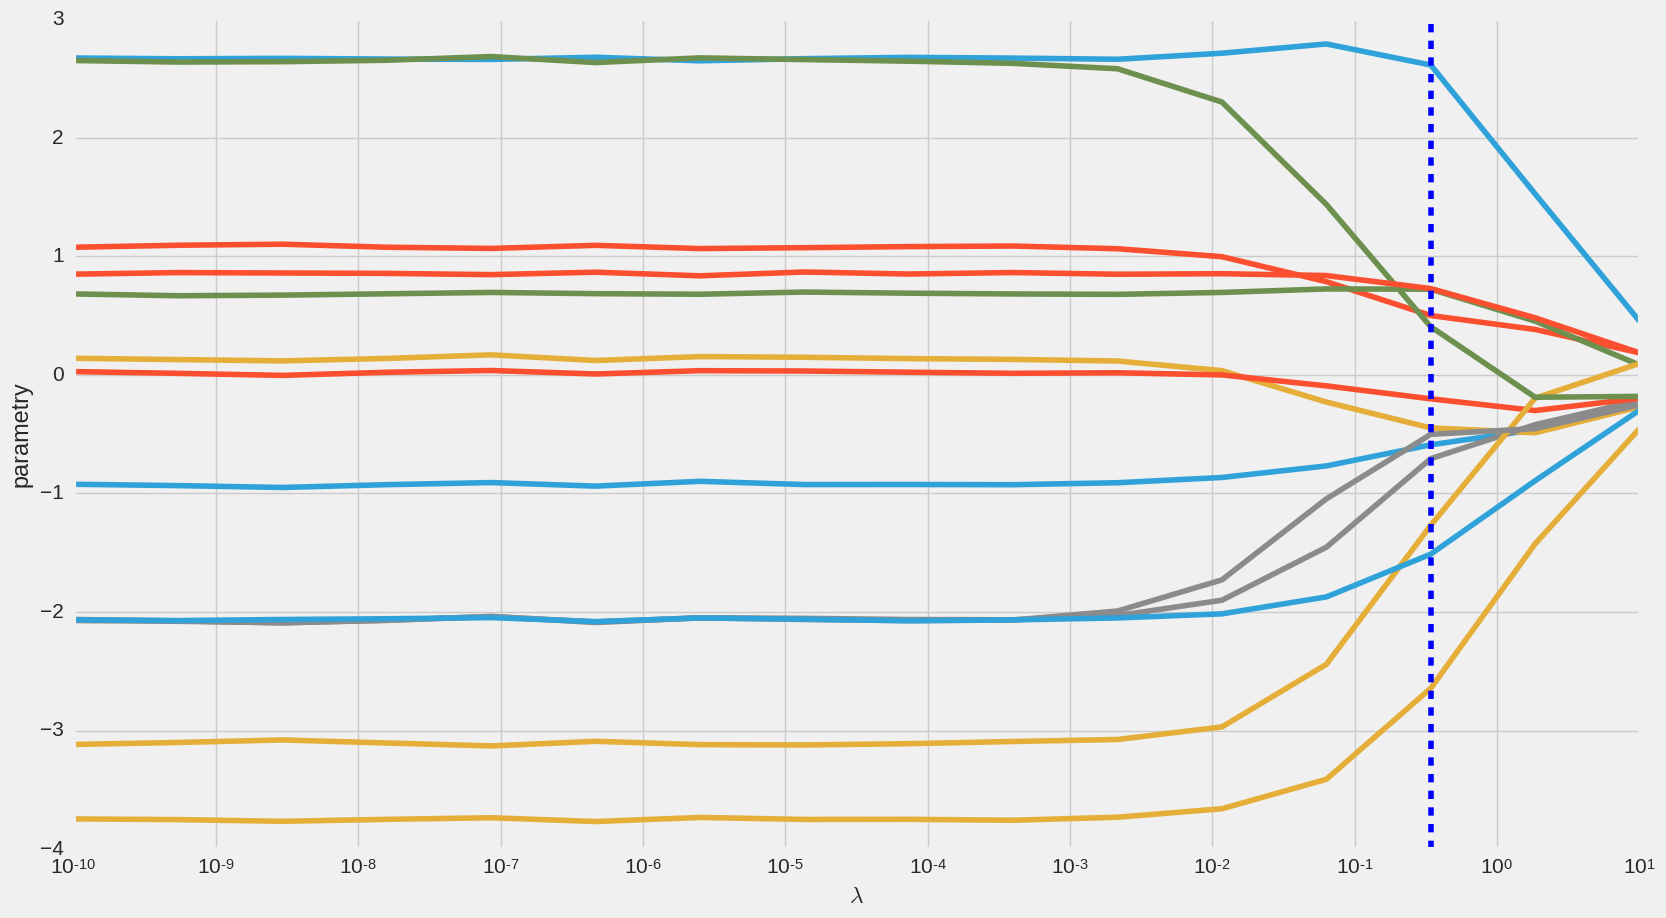

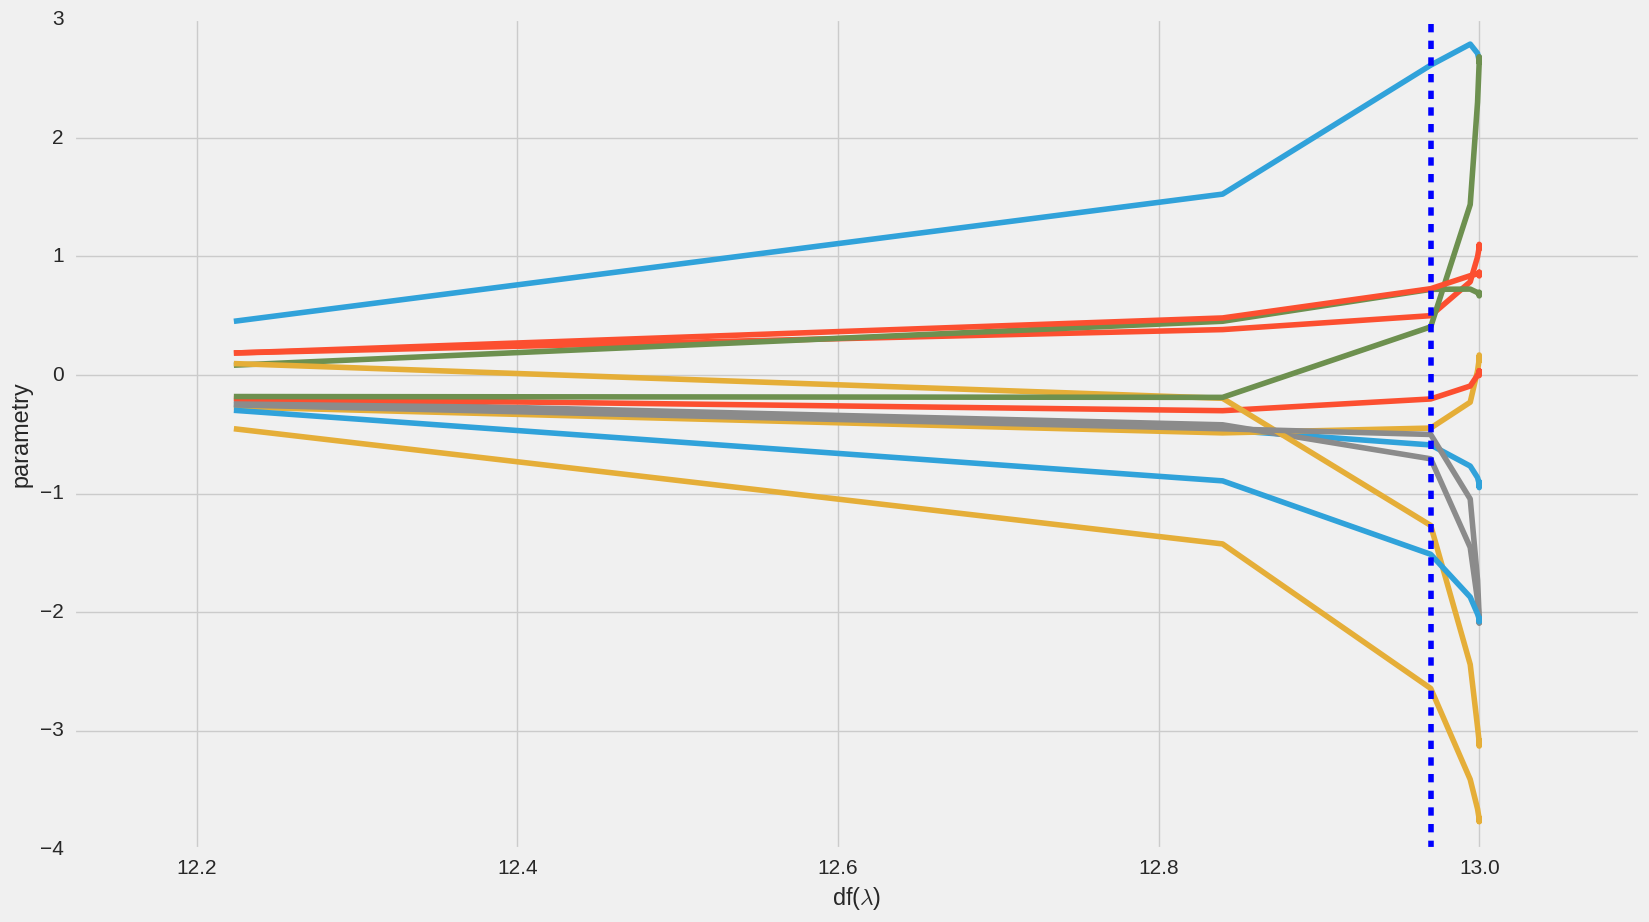

In [61]:
regression_regularization(data='boston', sss=4, penalty_mode='l2', n_iter=250)

Singular values are [ 55.66   26.919  25.06   20.834  20.55   18.27   16.515  14.165  11.848
  10.557   9.706   9.252   5.669]
Data set: boston, n_examples = 506, n_features = 13
l1 regularization
	Best score = 33.9529661984 obtained for regularization with lambda = 0.063095734448


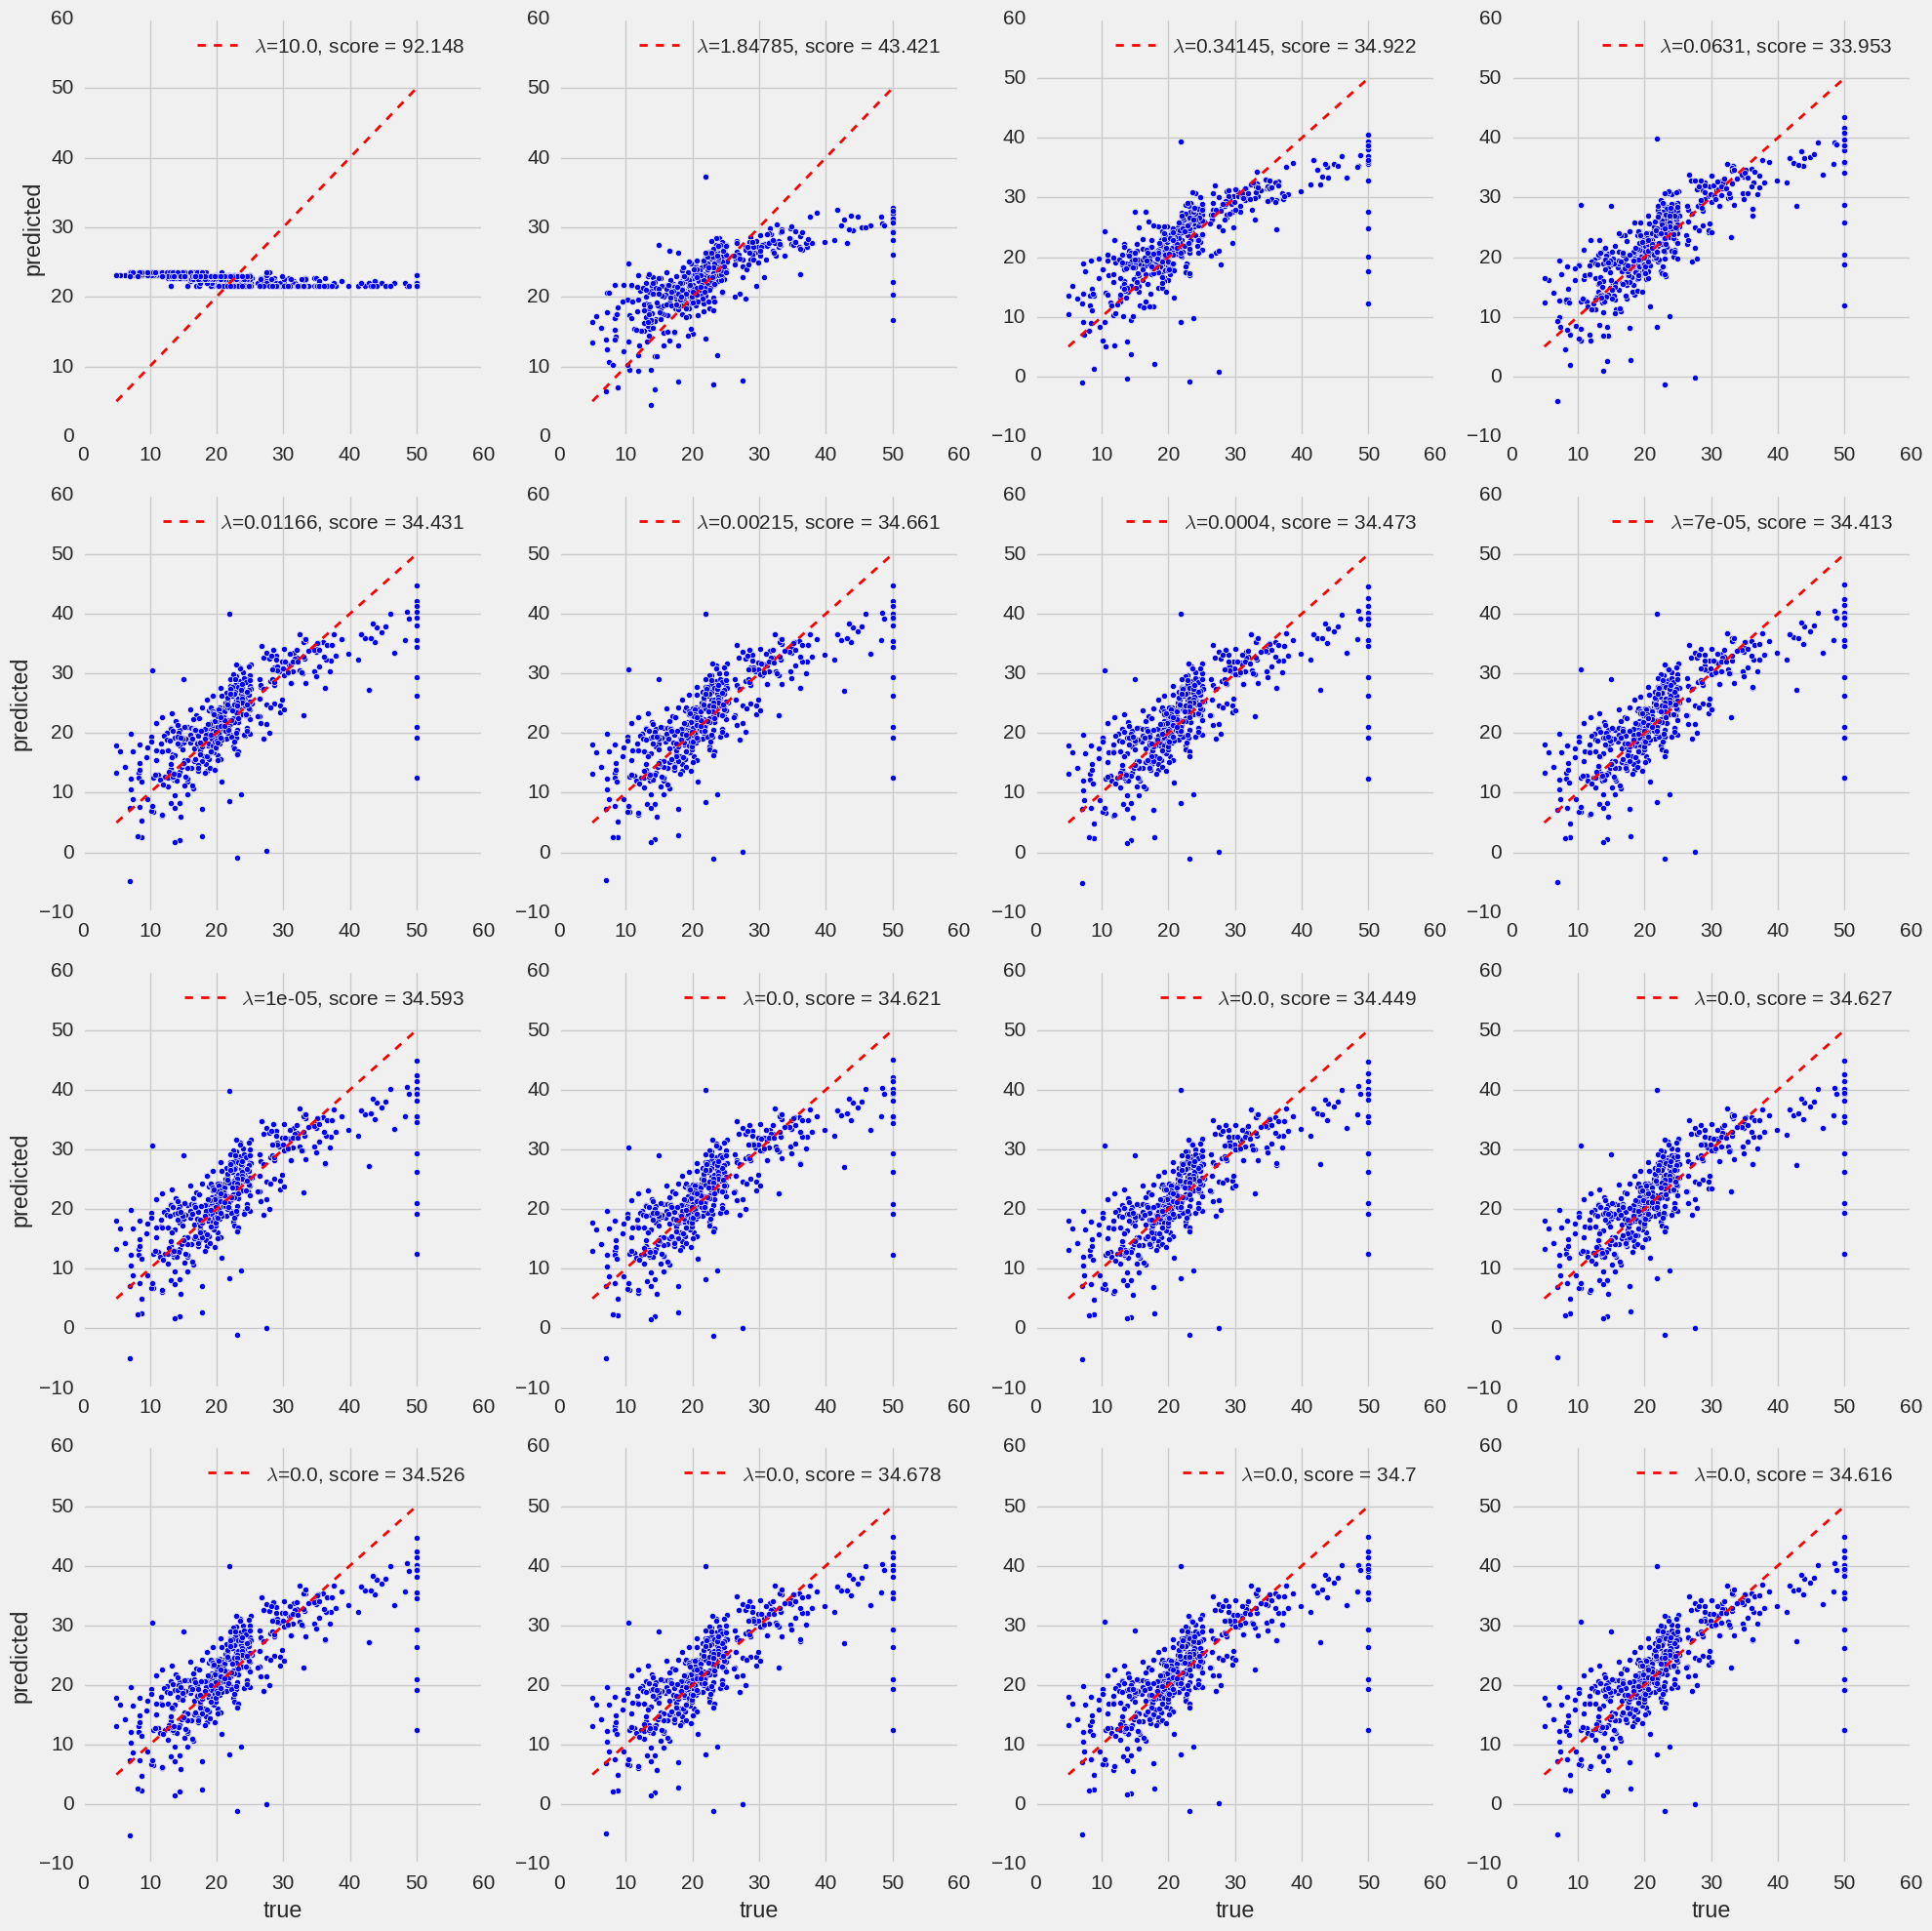

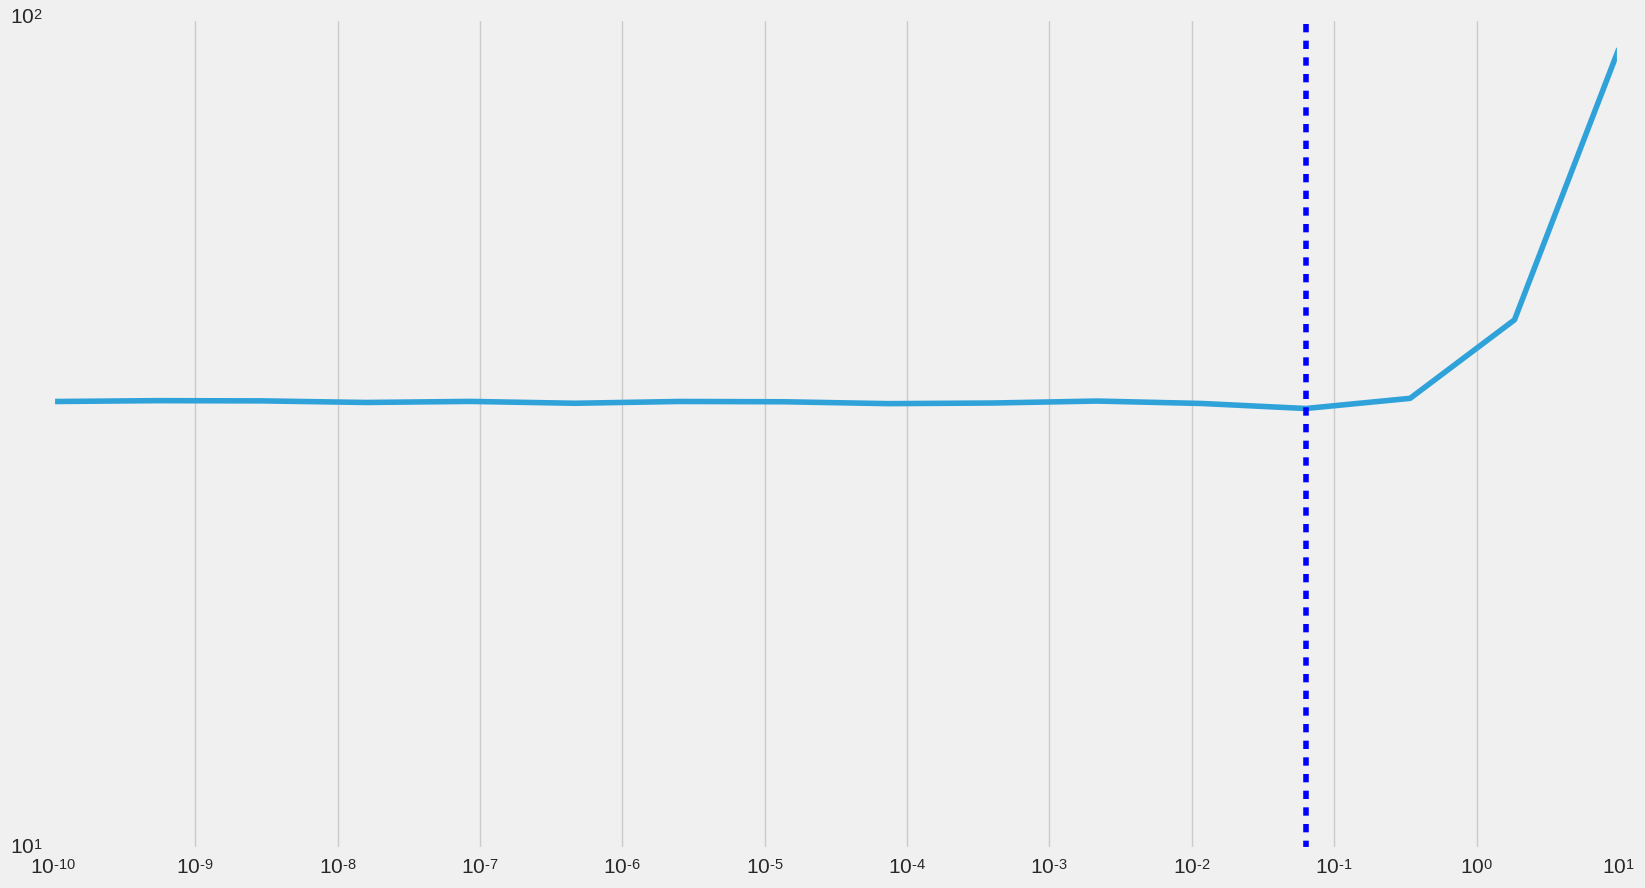

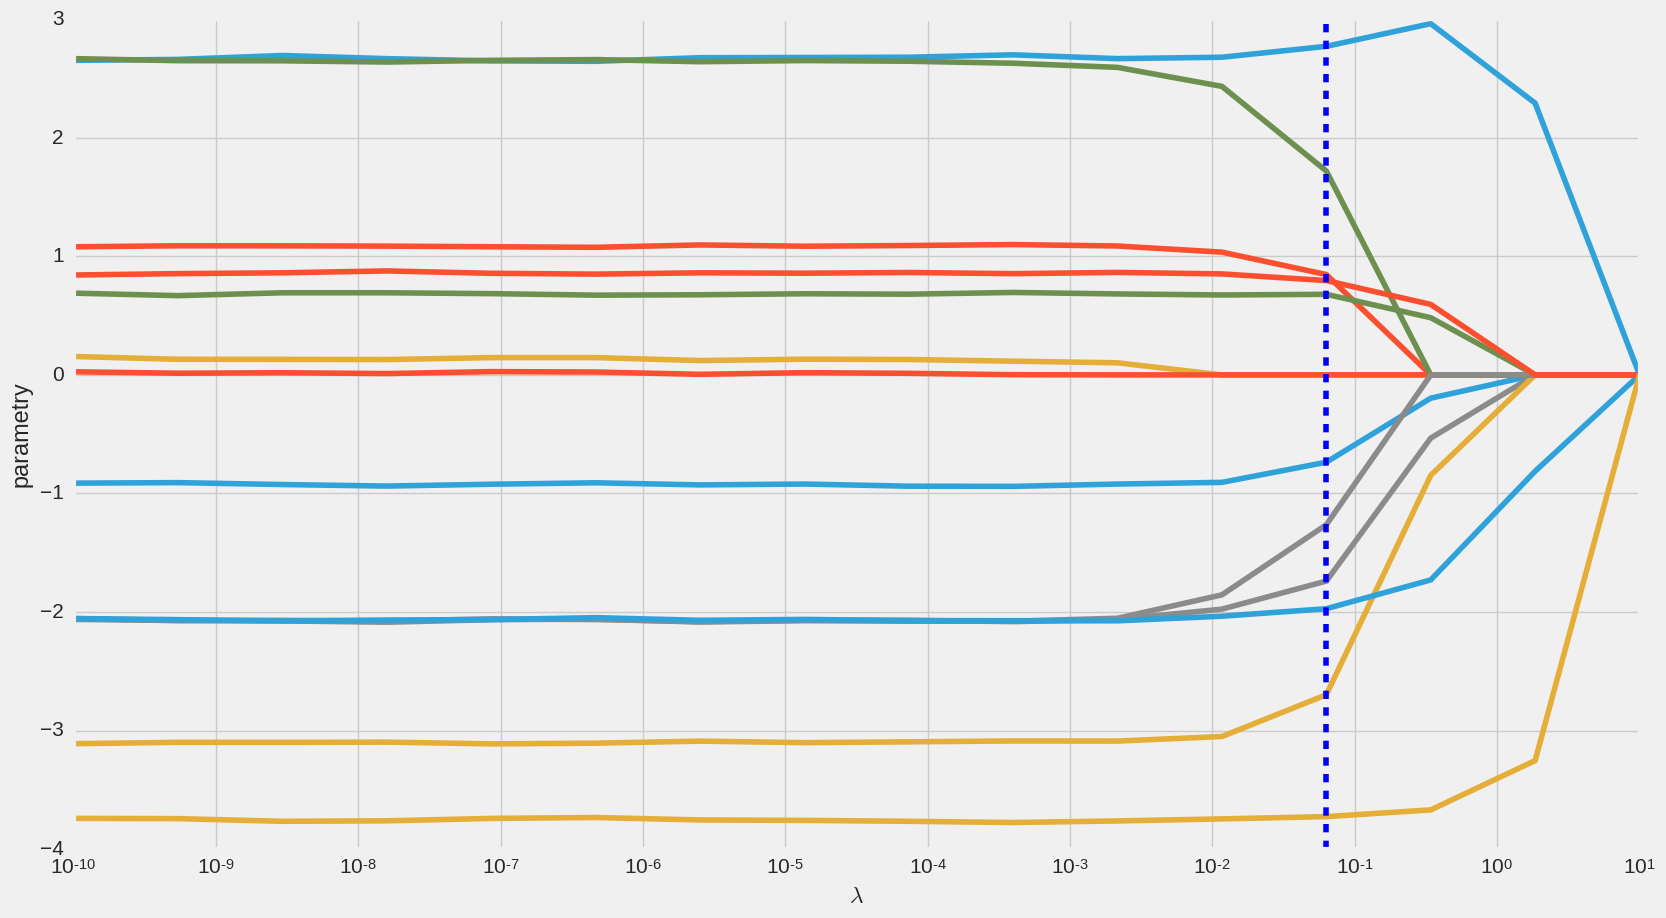

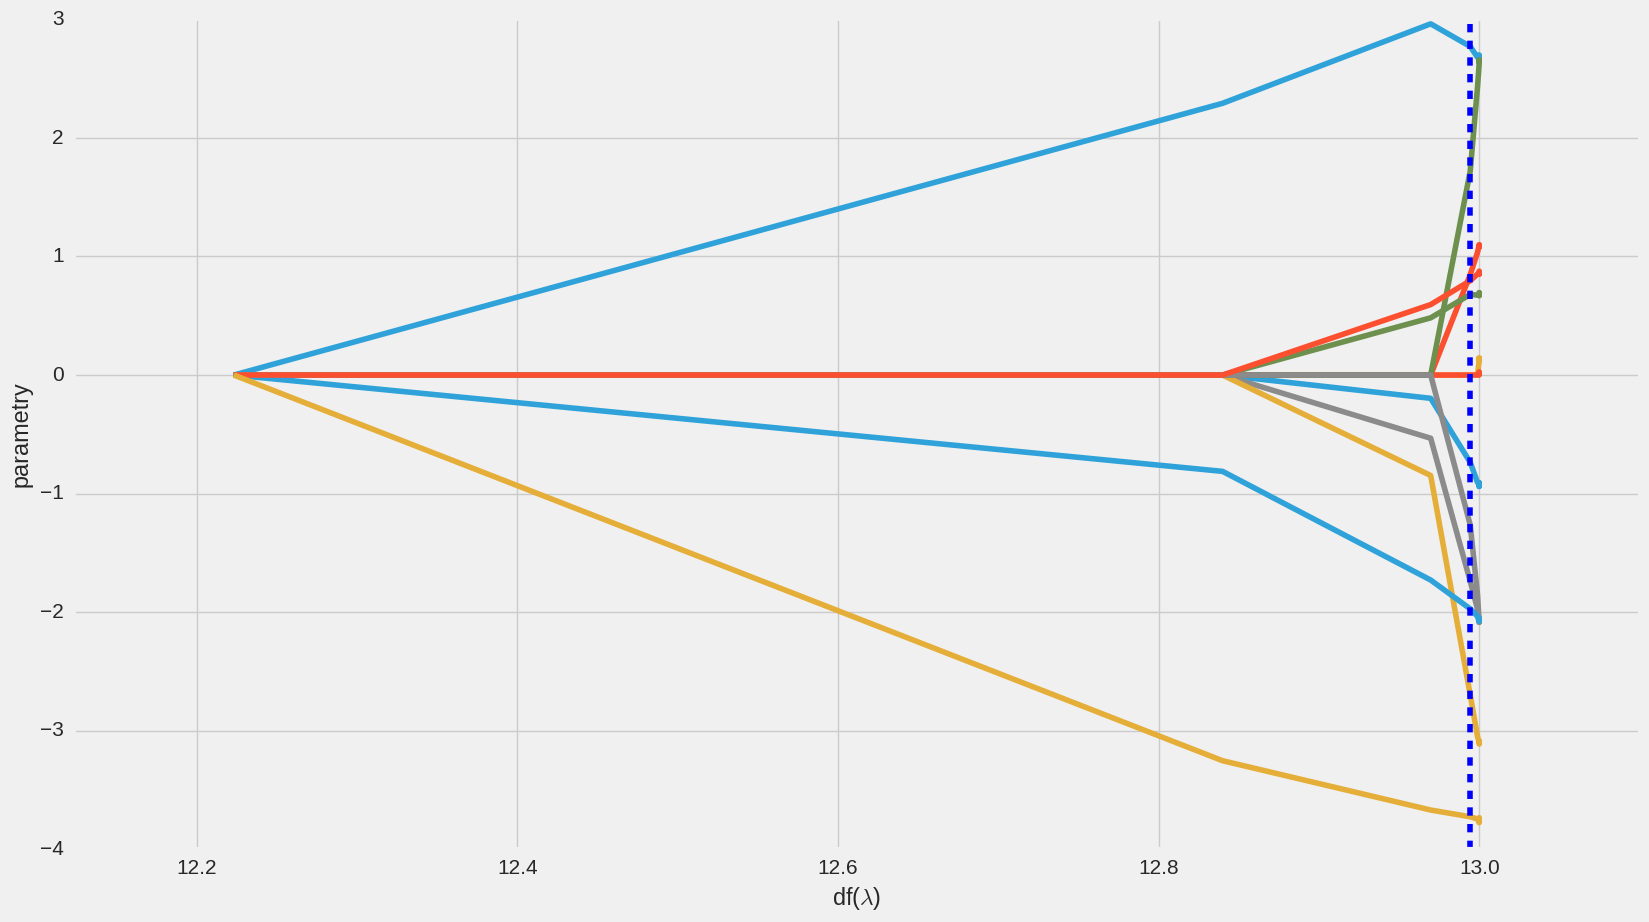

In [63]:
regression_regularization(data='boston', sss=4, penalty_mode='l1', n_iter=250)

In [64]:
def plot_regularization_isolines():
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    x = np.linspace(-1, 1, 1000)
    y = [np.sqrt(1. - v ** 2) for v in x]
    y1 = [-np.sqrt(1. - v ** 2) for v in x]
    ax[0].plot(x, y, c='c')
    ax[0].plot(x, y1, c='c')
    ax[0].set_xlim(-1.1, 1.1)
    ax[0].set_ylim(-1.1, 1.1)
    ax[0].grid()
    ax[0].set_title("Ridge regression")

    y = [(1. - abs(v)) for v in x]
    y1 = [-(1. - abs(v)) for v in x]
    ax[1].plot(x, y, c='m')
    ax[1].plot(x, y1, c='m')
    ax[1].set_xlim(-1.1, 1.1)
    ax[1].set_ylim(-1.1, 1.1)
    ax[1].grid()
    ax[1].set_title("Lasso")

    alpha = 0.2
    y = [(1. - abs(v)) for v in x]
    y1 = [-(1. - abs(v)) for v in x]
    ax[2].plot(x, y, c='k')
    ax[2].plot(x, y1, c='k')
    ax[2].set_xlim(-1.1, 1.1)
    ax[2].set_ylim(-1.1, 1.1)
    ax[2].grid()
    ax[2].set_title("Elastic net")

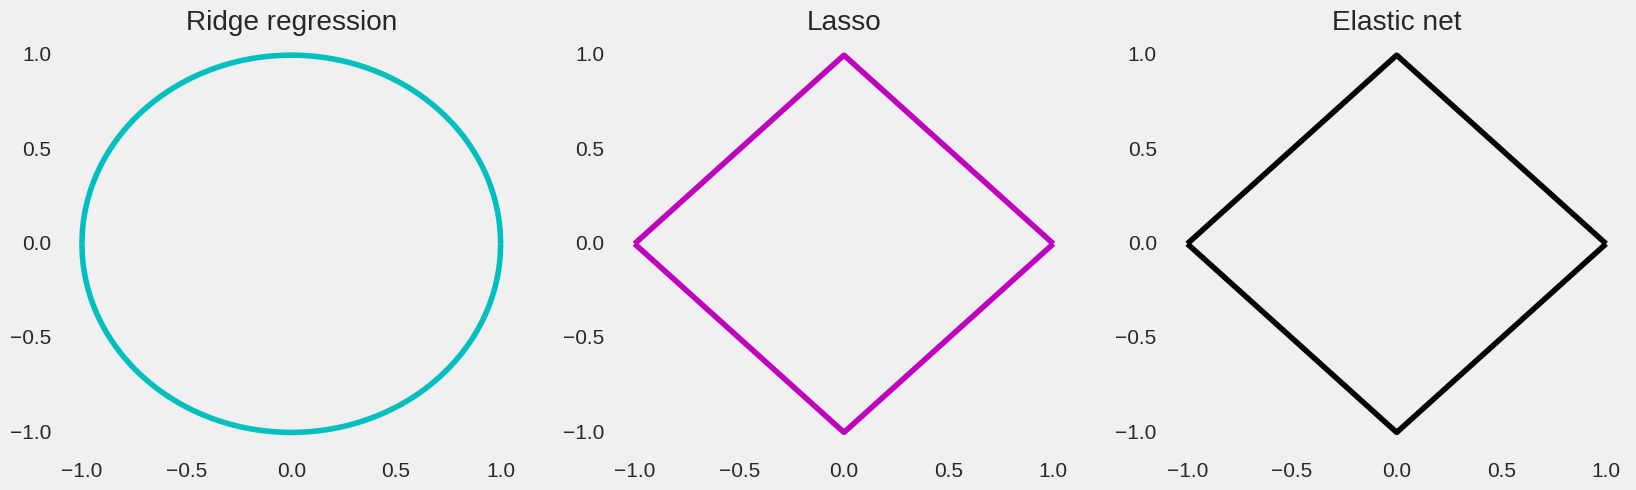

In [65]:
plot_regularization_isolines()

## Bardziej ogólne sformułowanie

* bardziej ogólne sformułowanie ma postać
  $$\boxed{\hat\theta = \underset{\theta}{\arg\min}\frac{1}{2}\sum_{n=1}^N\left(y_n-\theta^Tx_n\right)^2+\lambda\sum_{j=1}^M|\theta|^q\;}$$
  dla różnych $q$. 
  
* kontury dla różnych wartości $q$: izolinie pokazują obszary o tej samej wartości czynnika regularyzacji [z Hastie et al.] 
  <img src="../mum_figures/regularization_contours.png" width="105%"/>
  
* wpływ ograniczeń dodawanych przez regularyzację na znalezione rozwiązanie [rysunek z Hastie et al.]
  <img src="../mum_figures/regularization.png" width="90%"/>
  * niebieskie obszary odpowiadają rozwiązaniom dla których regularyzator jest mniejszy od jakiejś wartości $\rho$
  * dla $q=2$ (metoda __ridge regression__) będzie nim najbliższy do minimum funkcji kosztu (nieograniczonej) na izolinii regularyzatora
  * dla $q=1$ (metoda __lasso__) rozwiązanie będzie "ściągane" w kierunku osi współrzędnych danych
    * o ile $\lambda$ będzie wystarczająco wysokie, to wiele parametrów związanych z _nieistotnymi_ atrybutami będzie wyzerowanych
    * w efekcie rozwiązanie będzie __rzadsze__
    
  
* rozwiązanie ridge regression jest czułe na względne wielkości atrybutów
    * konieczne __normalizacja__ i __centrowanie__ atrybutów przed budową modelu
    * to wymaga niezależnego rozwiązania dla parametru bias $\theta_0$
    
* Hastie et al. definiują __efektywne stopnie swobody__ jako 
$$\begin{align}
df(\lambda)&=tr[X(X^TX+\lambda I)^{-1}X^T]\\
&=\sum_{j=1}^l\frac{d_j^2}{d_j^2+\lambda}
\end{align}$$
  * $d_j$ są składowymi głównymi macierzy $X$
  * $df(\lambda)\longrightarrow 0$ dla $\lambda\longrightarrow\infty$
  * $df(\lambda)=l$ dla $\lambda=0$
  * wynika z prostej analizy $X\hat\theta$ podstawiając $X=UDV$ z analizy składników głównych
  
  * ridge regression redukuje w __największym stopniu__ parametry odpowiadające atrybutom o __najmniejszej wariancji__
  
  
  
* rozwiązanie regularyzacji pozwala na ustrzeżenie się przed nadmiernym dofitowaniem rozwiązaniem do danych
  * problem znalezienia optymalnych funkcji bazowych zostaje zamieniony na problem dopasowania parametrów regularyzacji

### Metoda Lasso

* sformułowana przez Hastie et al.
$$\boxed{\hat\theta=\underset{\theta}{\arg\min}\frac{1}{2}\sum_{n=1}^N\left(y_n-\theta_0-\sum_{j=1}^l\theta^T_jx_{nj}\right)^2+\lambda\sum_{j=1}^l|\theta_j|\;
}$$
  * brak rozwiązania w zamknietej postaci, jednak istnieją efektywne algorytmy
  * mała wartość ograniczenia na czynnik kary (albo duże $\lambda$) powoduje, efektywne __wyzerowanie__ parametrów dla niektórych składowych wejścia
    * lasso jest efektywnym algorytmem wyboru podzbioru cech wejściowych
    
    

### Elastic net
* Zou i Hastie w 2005 sformułowali __elastic net__ jako pewnego rodzaju połączenie ridge regression i lasso
$$\boxed{\hat\theta=\underset{\theta}{\arg\min}\frac{1}{2}\sum_{n=1}^N\left(y_n-\theta_0-\sum_{j=1}^l\theta^T_jx_{nj}\right)^2+\lambda\sum_{j=1}^l\left(\alpha\theta_j^2+(1-\alpha)|\theta_j|\right)\;
}$$
* kontury dla _elastic net_ 
  <img src="../mum_figures/elastic_net.png" width="65%"/>[rysunek z Hastie et al.]
  * kontury wydają się bardzo podobne
    * kontur dla $\sum_j|\theta_j|^q$ dla $q=1.2$ ma __zaokrąglone__ brzegi
    * kontur dla $\sum_j\left(\alpha\theta_j^2+(1-\alpha)|\theta_j|\right)$ ma __ostre__ rogi
    * ostre rogi pozwalają algorytmowi (podobnie jak jak w przypadku lasso) ustawiać wartości parametrów __dokładnie__ w zerze


<img src="../mum_figures/bias_variance_decomposition.png" width="75%"/>
<img src="../mum_figures/bias_variance_tradeoff.png" width="75%"/>[rysunki za Hastie et al.]

### Najlepszy podzbiór atrybutów

* zadanie: znaleźć zbiór atrybutów, który daje najniższą sumę kwadratów błędów
  * przegląd __wszystkich__ możliwych podzbiorów jest zbyt złożony już dla niewielkiej liczby atrybutów


* krok po kroku __w przód__
    * rozpoczyna od biasu, który jest średnią z wartości zmiennej zależnej $y$
    * w każdym kroku wyszukuje atrybut __najlepiej__ poprawiający dopasowanie i dodaje go do zbioru
    * zachłanny
   
   
* krok po kroku __wstecz__
    * rozpocznij od pełnego modelu
    * w każdym kolejnym kroku usuwaj atrybut o najmniejszym wpływie na roziązania
    * do użycia __tylko__ jesli liczba przykładów jest większa od liczby parametrów
    
    
* zmienne często pojawiają się w grupach
  * to pozwala usunąć więcej niż jedną zmienną w jednym kroku
  * z drugiej strony atrybut $k$ często niesie wiedzę __tylko__ w połączeniu z atrybutem $j$, a usuwane (dodawane) są niezależnie

### Porównanie metod

* ridge regression skaluje parametry w sposób ciągły
* lasso zmniejsza (zwiększa) parametry o stały parametr $\lambda$ powodując _obcięcie_ do zera w rogach i utworzenie rzadkiej reprezentacji
  * elastic net jest podobna
* metody redukcji modeli podejmują podejście __holistyczne__ redukując cały czas __wszystkie__ parametry
  * to pozwala na uwzględnienie współzależności atrybutów i ich jednoczesnego wpływu na rozwiązanie


# Przekleństwo wymiarowości
* jeśli zdecydujemy się szukać komputera z zadanym typem procesora oraz wymiarem, to rozwiązaniem będzie jakaś frakcja wszystkich dostępnych
  * jeśli dodamy do tego by miał GPU oraz oraz dużo pamięci, to frakcja szybko spadnie
  * z dodaniem każdego wymiaru liczba spełniających gwałtownie maleje
  
* niech dane będą w (hiper-)sześcianie, o boku 2, wycentrowanym w środku układu współrzędznych
  * niech dane będą równomiernie rozłożone
* jaka frakcja wszystkich danych leży w _jednostkowej_ odległości od środka układu współprzędnych
  * niech wymiar $D=2$ $$f_2=\frac{\pi r^2}{(2r)^2}=\pi/4\simeq0.785$$
  * dla $D=3$ $$f_3=\frac{(4/3)\pi r^3}{(2r)^3}=\pi/6\simeq0.523$$
  * dla wyższych wymiarów
  $$\begin{align}
  V_D(r)&=\frac{2r^D\pi^{D/2}}{D\Gamma(D/2)}\\
  f_D&=\frac{V_D(r)}{(2r)^D}=\frac{\pi^{D/2}}{D2^{D-1}\Gamma(D/2)}
  \end{align}$$
które bardzo szybko zmierza do zera
  * bardzo szybko w sąsiedztwie danego punktu nie będzie żadnego innego
  * aby utrzymać równomierny rozkład, liczba punktów musi rosnąć _wykładniczo_
  * szczególnie w przypadkach prostych algorytmów
    * podział całej przestrzeni na _kostki_
    * dla $D=1$ potrzeba $N$
    * dla $D=2$ już $N^2$,\dots
    
    
    
* niech punkty będą rozłożone równomiernie w kuli jednostkowej w wymiarze $D$
* jaka frakcja danych leży na "skórce" o grubości $\epsilon$
  * objętość kuli o promieniu $D$ to $$V_D(r)=K_Dr^D,$$ gdzie $K_D$ jest stałą zależną od od $D$
  * ułamek danych w skórce to $$\frac{V_D(1)-V_D(1-\epsilon)}{V_D(1)}=1-(1-\epsilon)^D$$
* trzeba być __bardzo ostrożnym__ obserwując przykłady w dwóch/trzech wymiarach
  * rzeczywiste dane są jednak zwykle ograniczone
    * to ograniczenie może mieć postać bardzo specyficzną
    * metody rozpoznawania rozmaitości, gdzie umieszczone są dane
    
* PRZYKŁAD
  * danymi są miasta na kuli ziemskiej
  * interesują nas ich położenia i odległości
  * jednak _legalne_ są odległości __tylko__ po powierzchni!

# Bias-variance dilemma
* złożone modele dopasowują się zbyt dokładnie do danych (overfitting)
* modele proste nie dopasowują się zanadto, ale mogą nie mieć wystarczającej mocy
* konieczny jest wybór


* mamy dane $\{(x_1,y_1),\dots\}$
  * dane pochodzą z procesu i są obarczone błędem $y_i=f(x_i)+\epsilon$
  * dopasowujemy liniową funkcję $\hat{f}(x)$
  * załóżmy, że mamy więcej dostępnych danych i dopasowujemy nowe $\hat{f}(x)$ dla każdego podzbioru
  * uśredniona wartość daje nam $E[\hat{f}(x)]$
  * jednak prawdziwy proces jest nieliniowy!
    * stąd różnica między wartością prawdziwą $f(x)$ a średnim dopasowaniem
      * suma kwadratów różnic to __squared bias__ $$E[(f(x)-E[\hat{f}(x)])^2]$$
    * funkcja modelu jest liniowa, stąd "odchylenie" (bias) w kierunku liniowych funkcji
    * bias jest wysoki
  * ponieważ obliczamy wiele dopasowań, dostajemy wiele różnic między $\hat{f}(x)$ a wartością średnią $E[\hat{f}(x)]$
  * to __wariancja__ dopasowań $$E[(\hat{f}(x)-E[\hat{f}(x)])^2]$$
    * modele są bardzo podobne, stąd wariancja jest niska
  * ostatnim źródłem błędu dopasowania jest __szum__ pochodzący z różnic $y-f(x)$
  
<img src="../mum_figures/RojasBiasVarianceDilemma.png" width="65%"/>[rysunek za Rojas]

  * sytuacja przeciwna: prawdziwa funkcja jest liniowa a my dopasowujemy modele o wielu stopniach swobody
    * każdy indywidualny model overfituje dane
      * różne modele będą bardzo od siebie różne, stąd wysoka wariancja
    * jeśli mamy wystarczająco wiele danych, do średnia modeli będzie bliska prawdziwemu $f(x)$
      * bias jest niski
      
      
* błąd kwadratowy ma postać
$$E[(y-\hat{f}(x))^2]=E[(f(x)-\hat{f}(x)+\epsilon)^2]=E[(f(x)-\hat{f}(x))^2] +\epsilon^2$$
* rozwijając
$$\begin{align}E[(y-\hat{f}(x))^2]&=E[(f(x)-\hat{f}(x))^2] +\epsilon^2\\
&=E[(f(x)-E[\hat{f}(x)]+E[\hat{f}(x)]-\hat{f}(x))^2] +\epsilon^2\\
&=\underbrace{E[(f-E[\hat{f}])]^2}_{bias^2}+\underbrace{E[(\hat{f}-E[\hat{f}])^2]}_{wariancja}+2E(f-E[\hat{f}])(E[\hat{f}]-\hat{f})+\epsilon^2\\
&=\underbrace{E[(f-E[\hat{f}])]^2}_{bias^2}+\underbrace{E[(\hat{f}-E[\hat{f}])^2]}_{wariancja}+\epsilon^2
\end{align}$$
  * budowa modelu polega na znalezieniu kompromisu
    * proste modele zwykle lepiej generalizują, ale niedofitowują danych
  * budowa modeli złożonych, tzw. ensembli, często pomaga
    * wiele prostych modeli popełniających błędy w różnych miejscach przestrzeni danych

